In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm
from tqdm import tqdm
from contextlib import redirect_stdout
import io


import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

## Load masks

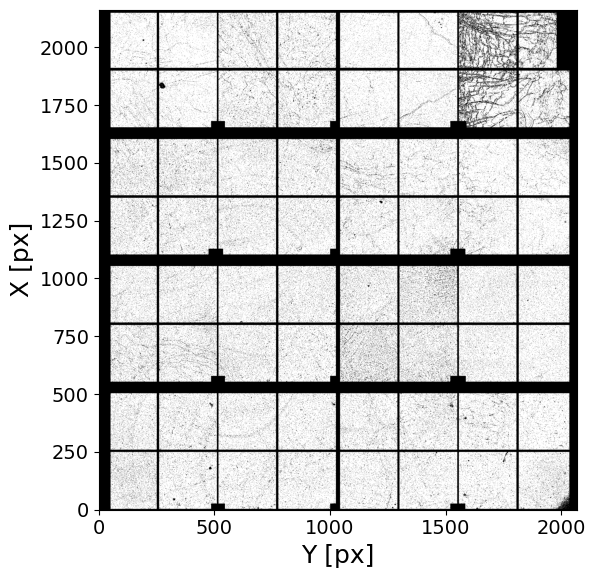

In [2]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

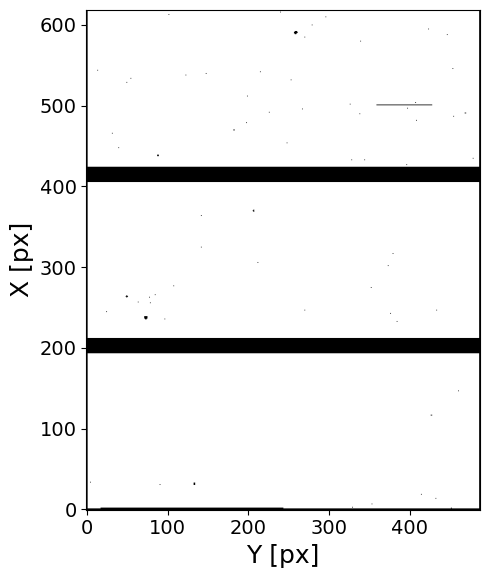

In [3]:
pilatus_mask = np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy').astype(bool)

plt.figure(figsize=(6, 6))
plt.imshow(~pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [4]:
###########
Q = 2.0
dq = 0.01
###########
Q=float(Q)

## XPCS scan: delcoup=10, T~16h (Ta2O5_2.5um, 2, 4)  
Tantala annealed, substrate towards the Eiger, see Kossel lines from Bragg diffraction of Si triggered by diffused scattering from the sample

#############################
command = mtimescan 0.001 2 86000501
Ei = 21.669991317784486
itime = 0.0011
T =  15.707186611111112 h
theta = 10.0
Qc = 1.91
#############################



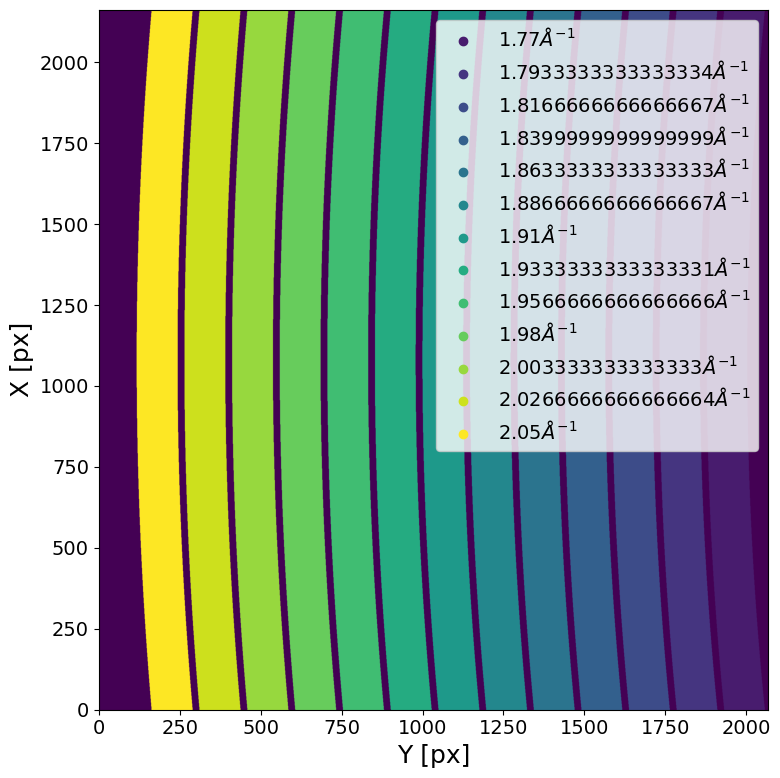

TypeError: unsupported operand type(s) for *: 'bool' and 'dict'

In [159]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 4
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, None
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_0002_0004.npy')
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask*Kossel_mask
##################################################################################

#e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Intensity analysis
Beam crashed two times!

In [55]:
########################
Nf_down1 = 15492456
Nf_up1 = 16790601
Nf_down2 = 21877393
Nf_up2 = 23830327
########################

In [56]:
####################
Lbin = 1
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)

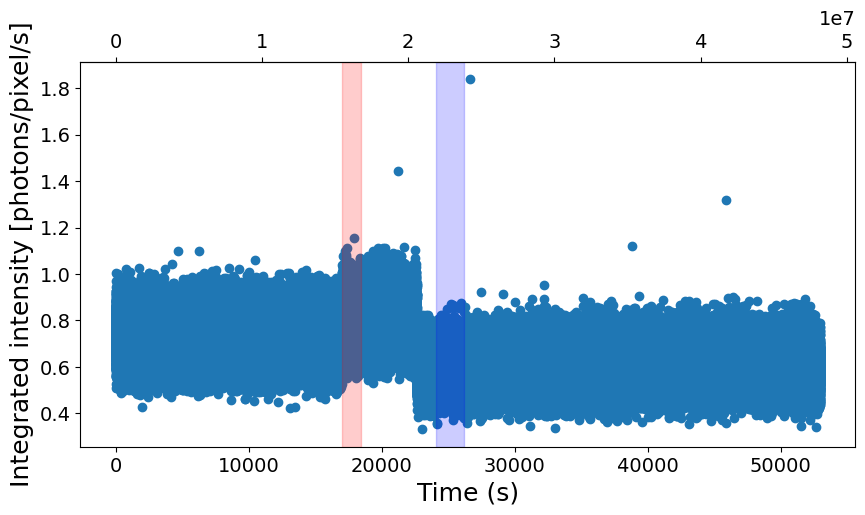

In [57]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.axvspan(t_It[Nf_down1//Nstep], t_It[Nf_up1//Nstep], color='red', alpha=0.2)
plt.axvspan(t_It[Nf_down2//Nstep], t_It[Nf_up2//Nstep], color='blue', alpha=0.2)
plt.show()

Cut the no-beam frams!

In [47]:
frame_mask = np.ones(e4m_data.shape[0], dtype=bool)
frame_mask[Nf_down1:Nf_up1] = False
frame_mask[Nf_down2:Nf_up2] = False
e4m_data = e4m_data[frame_mask, :]

Nf_downA = Nf_down1
Nf_downB = Nf_down2 - (Nf_up1 - Nf_down1)

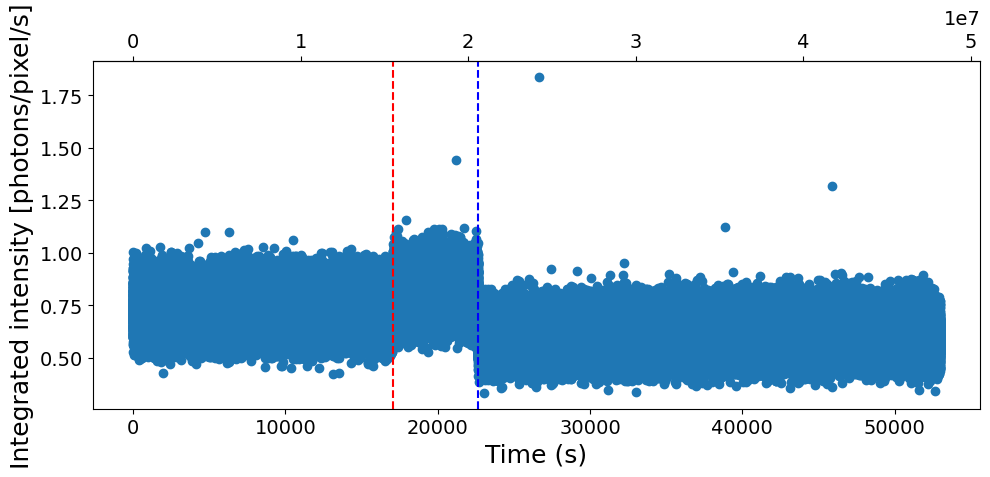

In [58]:
####################
Lbin = 1
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.axvline(t_It[Nf_downA//Nstep], color='red', linestyle='--', label='Nf_downA')
plt.axvline(t_It[Nf_downB//Nstep], color='blue', linestyle='--', label='Nf_downB')
plt.tight_layout(); plt.show()

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  4268374 pixels (of 4471016 => 95.47 %)
################################################################################



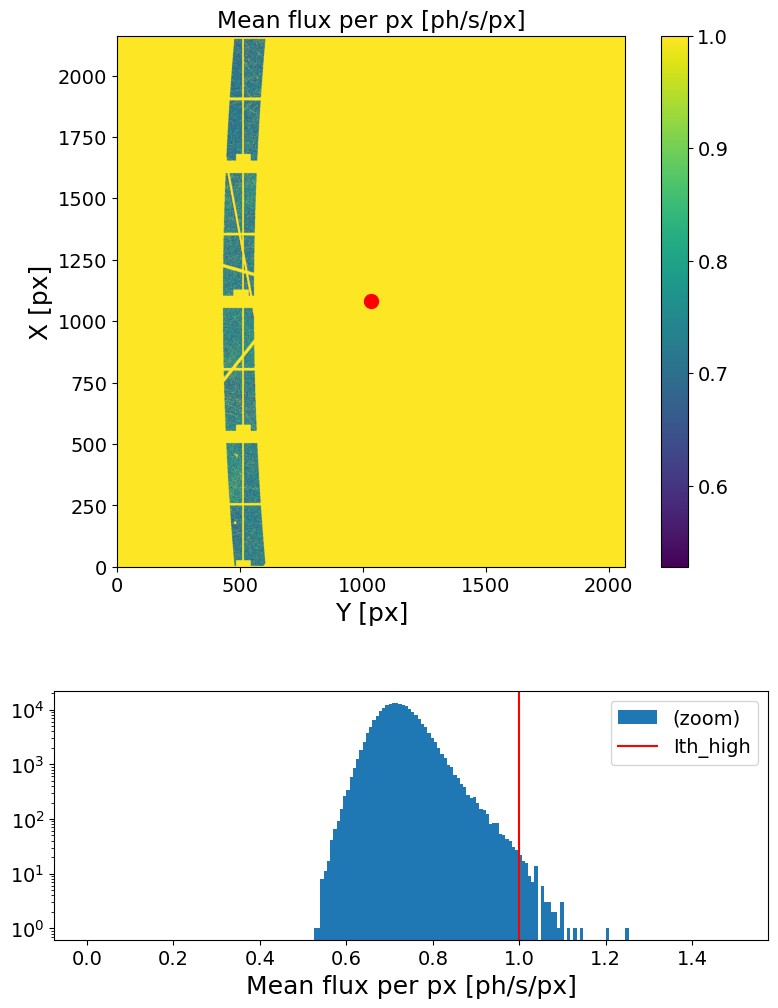

In [59]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Linear correlation 4 tests

In [60]:
###################
Nfi = None#int(0e7)
Nff = int(1e7)
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 16.71 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 2.43 s)
	 | 10000 frames X 202742 pixels
	 | memory usage (np.array @ float32) = 7.553 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 4.46 s)
	 | 10000 X 10000 squared matrix
	 | memory usage (np.array @ float32) = 0.373 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.36 s)



In [61]:
############################
t1, t2 = 0, 1000
vmin, vmax = 1.0, 1.025
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [62]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.06 s)



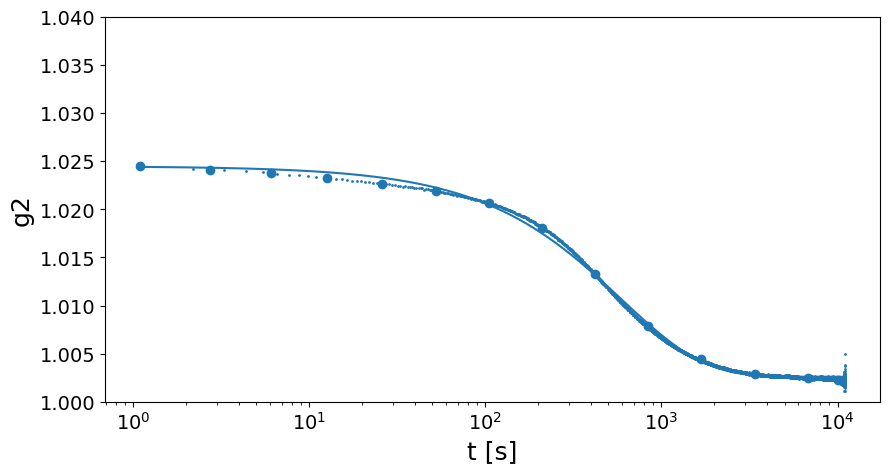

Parameters([('tau', <Parameter 'tau', value=np.float64(593.3660965715583) +/- 0.953, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(0.9215825294543795) +/- 0.00153, bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(0.02186946438720162) +/- 2.14e-05, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.0026049304857594) +/- 2.46e-06, bounds=[0:2]>)])

In [64]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')
    
    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.04)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [65]:
t_downA = Nf_down1*itime
t_downB = Nf_down2*itime
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nf_downA =', Nf_downA, ' =>  t_down1 =', t_downA)
print('Nf_downB =', Nf_downB, ' =>  t_down2 =', t_downB)
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nf_downA = 15492456  =>  t_down1 = 17041.7016
Nf_downB = 20579248  =>  t_down2 = 24065.1323
Nff =    = 48154460  =>  t_ff = 52969.906
#############################



Exception ignored in: <function ResourceTracker.__del__ at 0x7221c229bc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7d3e80d87c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [66]:
########################################
#N_segments = 5
t_segments = [0, 4e3, 6e3, 8e3, 10e3, 12e3, 14e3, 16e3, t_downA, 20e3, 22e3, t_downB, 26e3, 28e3, 30e3, 32e3, 34e3, 36e3, 38e3, 40e3, 42e3, 44e3, 46e3, 48e3, 50e3, t_ff] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [67]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

  4%|▍         | 1/25 [00:51<20:28, 51.17s/it]/gpfs/jazzy/data/visitor/hc6211/id10-coh/20250527/SCRIPTS_Trento/XPCSlibrary/XPCS_tools.py:827: RuntimeWarning: invalid value encountered in sqrt
  if    G2t.dtype==np.float32: g2, dg2 = mean_trace_float32(G2t)
100%|██████████| 25/25 [06:01<00:00, 14.46s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

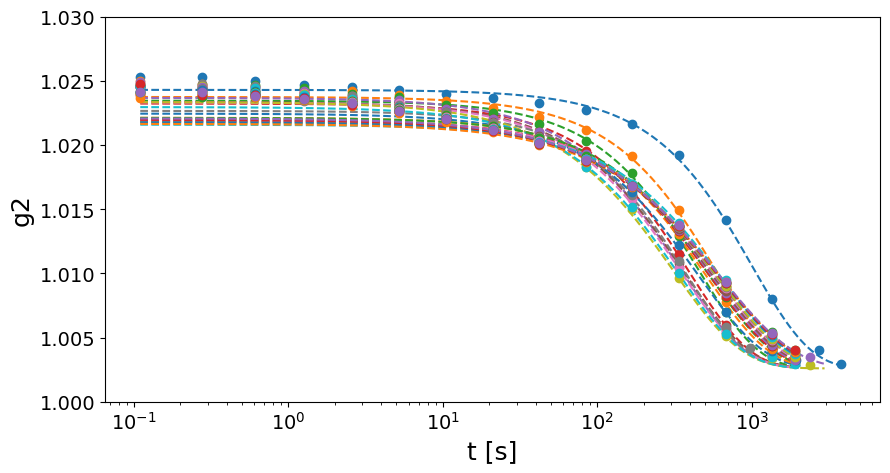

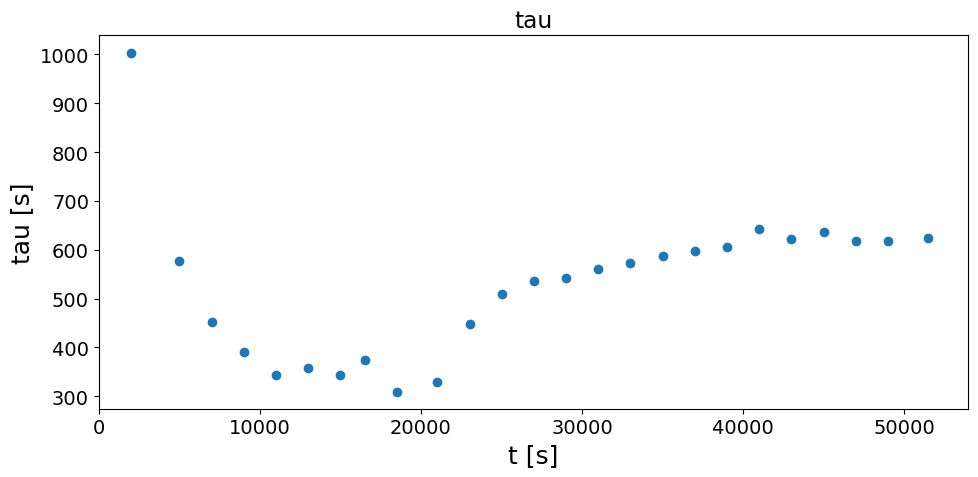

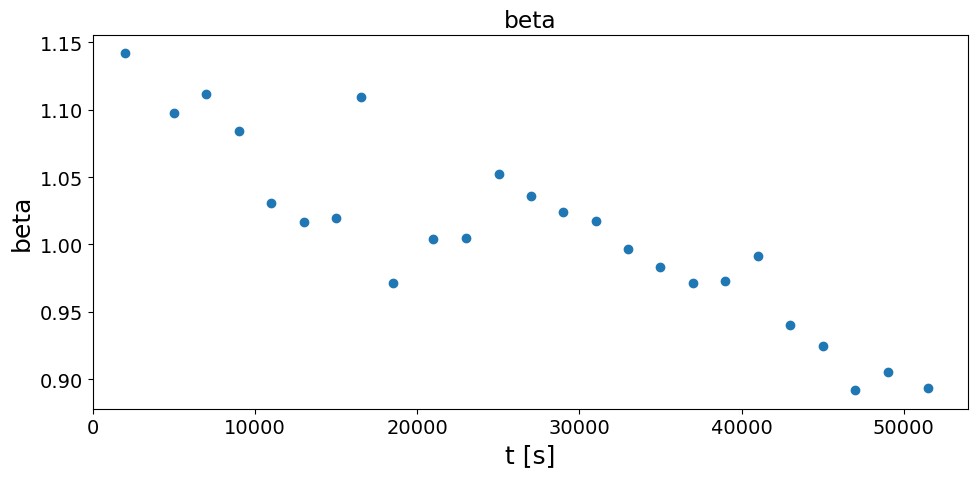

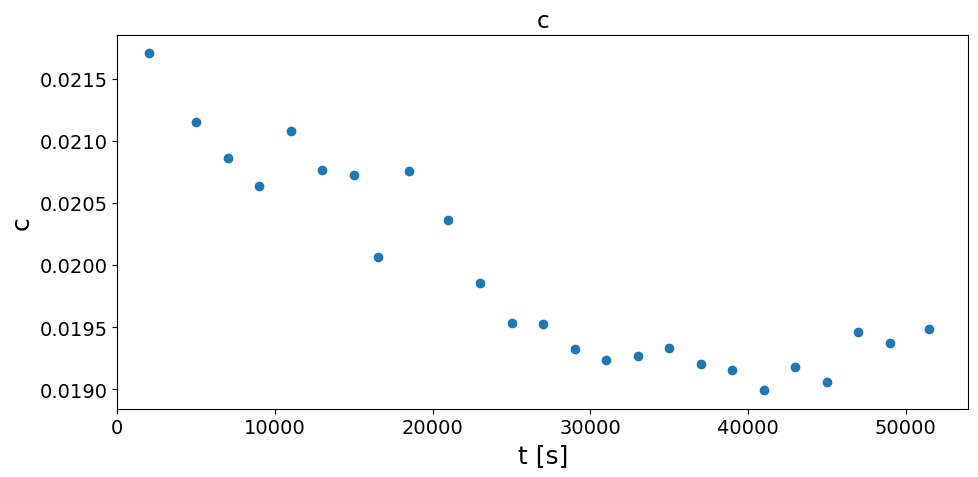

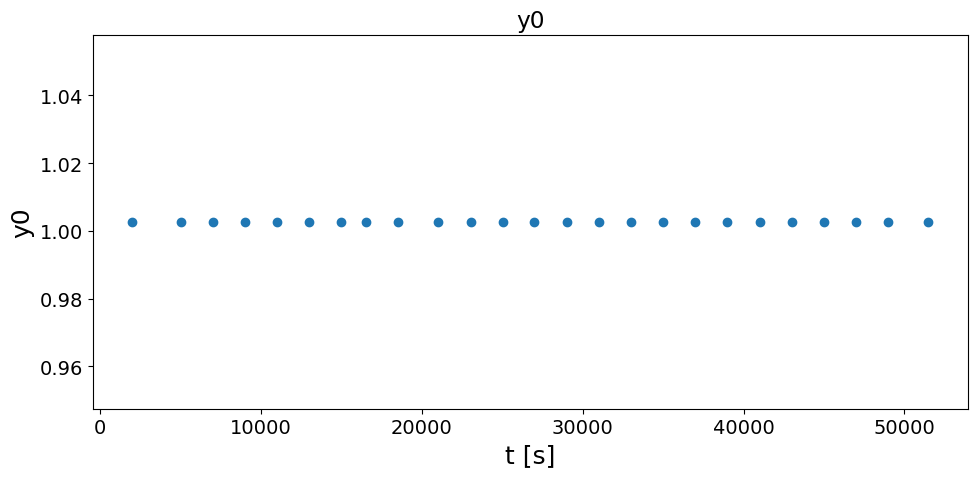

In [68]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00260493, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

### Multi-tau Correlation (TO BE REORDER!!!)

In [13]:
XPCS.print_Nf_choices(len(scan['fast_timer_period']))

       Nf = 51405338    =>    log2(Nf) = 25.62
----------------------------------------------------
   reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0       2**25                 24             34.7       17850906
1     3*2**24                 23              2.0        1073690
2    49*2**20                 19              0.0          25114
3  3137*2**14                 13              0.0           8730
----------------------------------------------------


In [ ]:
##### INPUTS #####
Nfi = 0
Nff = 0 +3*2**24
sparse_depth = 13
dense_depth = 23
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth, Nfi, Nff, mask=None)
#G2tmt = XPCS.get_G2tmt_4sparse_bypartialloading(RAW_folder, sample_name, Ndataset, Nscan, sparse_depth, dense_depth, Nfi, Nff, mask = load_mask, n_jobs=1)
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

In [ ]:
############################
vmin, vmax = 1.005, 1.025
lower_mt = 8
filter_layer = 12
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log', lower_mt=lower_mt, filter_layer=filter_layer)

In [ ]:
cut1 = XPCS.cut_G2tmt(itime, G2tmt, tmin=None, tmax=3000)
cut2 = XPCS.cut_G2tmt(itime, G2tmt, tmin=3000, tmax=6000)
cut3 = XPCS.cut_G2tmt(itime, G2tmt, tmin=6000, tmax=15000)
t_mt_1, g2_mt_1, dg2_mt_1 = XPCS.get_g2mt(itime, cut1)
t_mt_2, g2_mt_2, dg2_mt_2 = XPCS.get_g2mt(itime, cut2)
t_mt_3, g2_mt_3, dg2_mt_3 = XPCS.get_g2mt(itime, cut3)

In [ ]:
##################
t1_fit = 1
t2_fit = 1e8
##################

plt.figure(figsize=(10,5))
plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')
#plt.errorbar(t_mt_1, g2_mt_1, yerr=dg2_mt_1, fmt='o', label='CUT1')
#plt.errorbar(t_mt_2, g2_mt_2, yerr=dg2_mt_2, fmt='o', label='CUT2')
#plt.errorbar(t_mt_3, g2_mt_3, yerr=dg2_mt_3, fmt='o', label='CUT3')


popt, pcov = curve_fit(decorrelation_f, t_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], g2_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], p0=[1000, .8, .04, 1], bounds=([0, 0, 0, .9999], [np.inf, np.inf, np.inf, 1.1]))
x = np.arange(np.min(t_mt), np.max(t_mt)+1e5, 1e-2)
y = decorrelation_f(x, *popt)
plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()


print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')


## XPCS scan: delcoup=10, T=6h (Ta2O5_2.5um, 3, 9)  
Tantala annealed, substarte towards the beam

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  6.521323416666667 h
theta = 10.0
Qc = 1.91
#############################



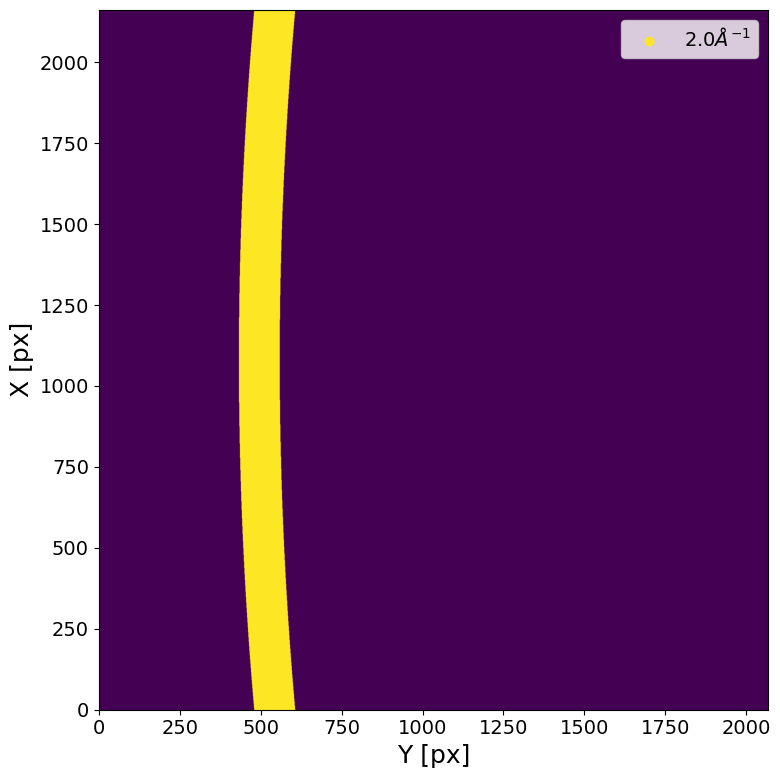

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/4269 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/4269 loops)
	 -> loading fil

In [ ]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 3
Nscan = 9
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, None
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  4260883 pixels (of 4471016 => 95.3 %)
################################################################################



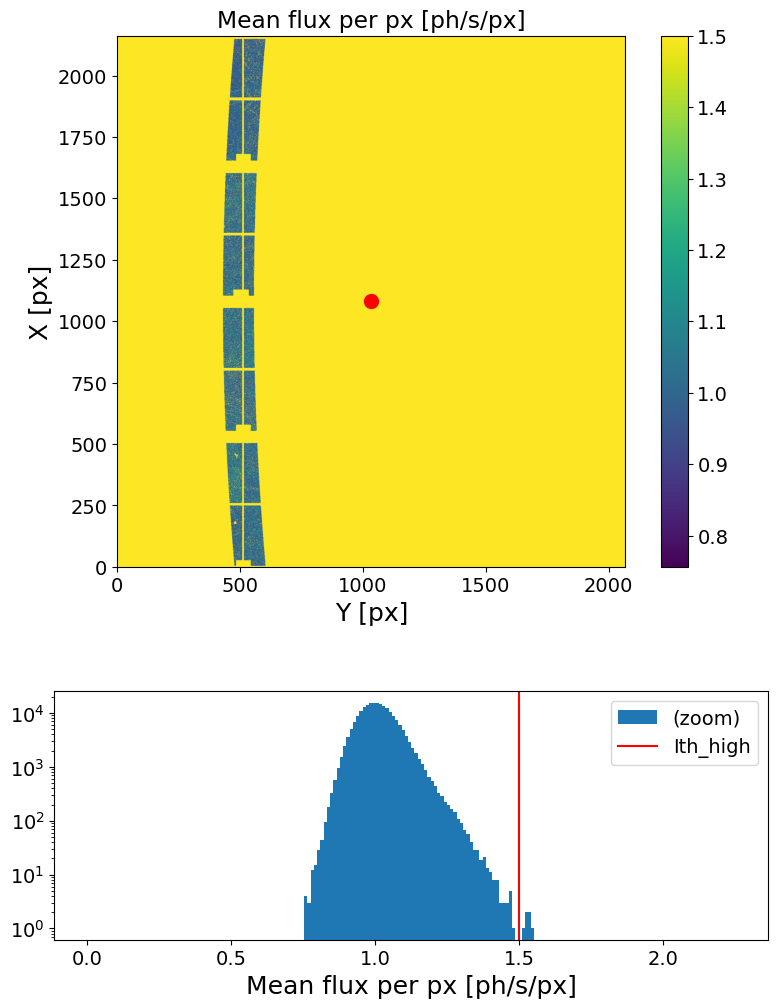

In [70]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1.5, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [71]:
####################
Lbin = 100
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

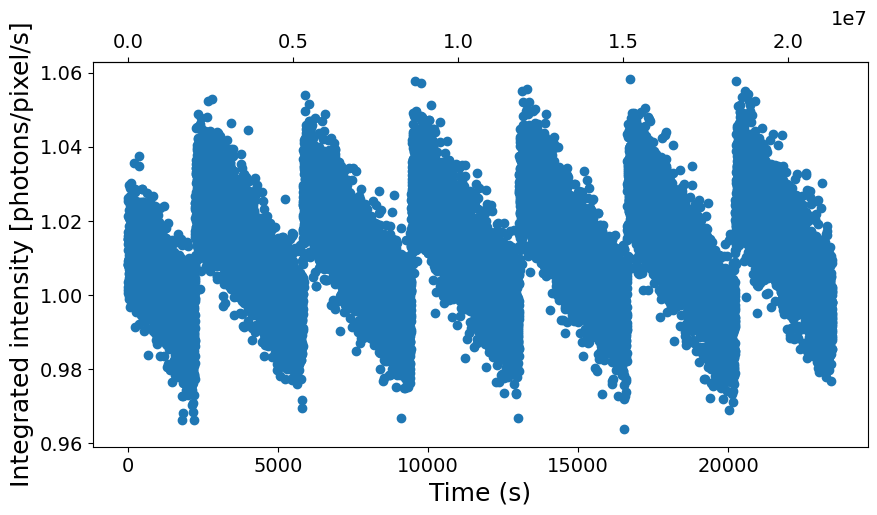

In [72]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.show()

### Pilatus

In [ ]:
#######################################
Nfi, Nff =  0, None
Nstep = 1000
#######################################

pilatus_data = ID10.load_pilatus(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, Nstep=Nstep)


Computing azimuthal integration...


100%|██████████| 12/12 [00:00<00:00, 111.89it/s]

Done! (elapsed time = 0.11 s)


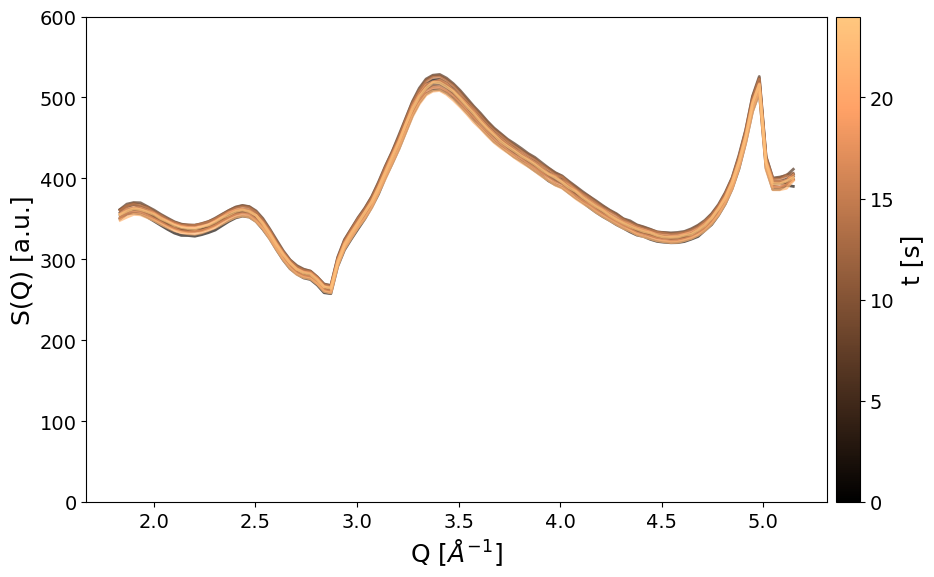

In [184]:
q1, Sq1, dSq1 = XPCS.get_Sq(pilatus_data, ponifile=pilatus_LaB6_poni, mask=pilatus_mask, npt=100)

Sq = Sq#/Sq[:,(q<2)*(q>1.8)].max(axis=1)[:,None]
XPCS.plot_Sq(q, Sq, itime=2, ylims=(0, 600) )#xlims=(1.8, 2.6), ylims=(.9, 1))

### Linear correlation 4 tests

In [73]:
###################
Nfi = None
Nff = int(1e7)
Lbin = 1000
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=True)

Loading frames ...


Done! (elapsed time = 19.74 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 3.32 s)
	 | 10000 frames X 210139 pixels
	 | memory usage (np.array @ float32) = 7.828 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 4.85 s)
	 | 10000 X 10000 squared matrix
	 | memory usage (np.array @ float32) = 0.373 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.37 s)



In [74]:
############################
t1, t2 = 0, 100
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [75]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.06 s)



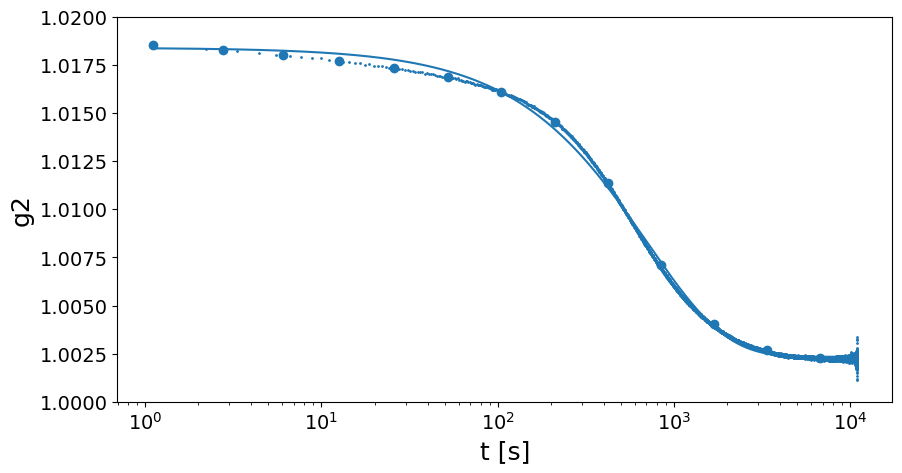

Parameters([('tau', <Parameter 'tau', value=np.float64(710.8655978505773) +/- 0.981, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(0.9745504149296095) +/- 0.00153, bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(0.01605410405974054) +/- 1.4e-05, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.002339150621552) +/- 1.91e-06, bounds=[0:2]>)])

Exception ignored in: <function ResourceTracker.__del__ at 0x794dbb88fc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x75745508fc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [76]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')
    
    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.02)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [ ]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 13506635  =>  t_ff = 14857.2985
#############################



In [80]:
########################################
#N_segments = 5
t_segments = [0, 1.5e3, 4.5e3, 7.5e3, 10.5e3, 13.5e3] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [81]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

  0%|          | 0/5 [00:00<?, ?it/s]/gpfs/jazzy/data/visitor/hc6211/id10-coh/20250527/SCRIPTS_Trento/XPCSlibrary/XPCS_tools.py:827: RuntimeWarning: invalid value encountered in sqrt
  if    G2t.dtype==np.float32: g2, dg2 = mean_trace_float32(G2t)
100%|██████████| 5/5 [03:21<00:00, 40.37s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

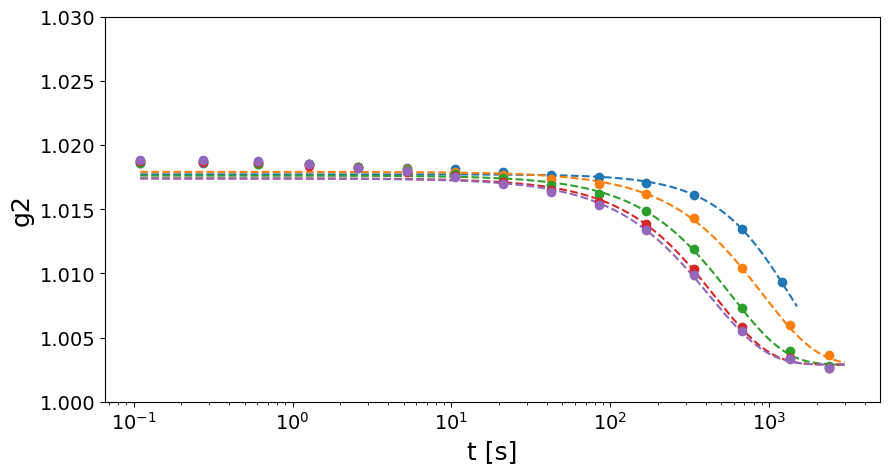

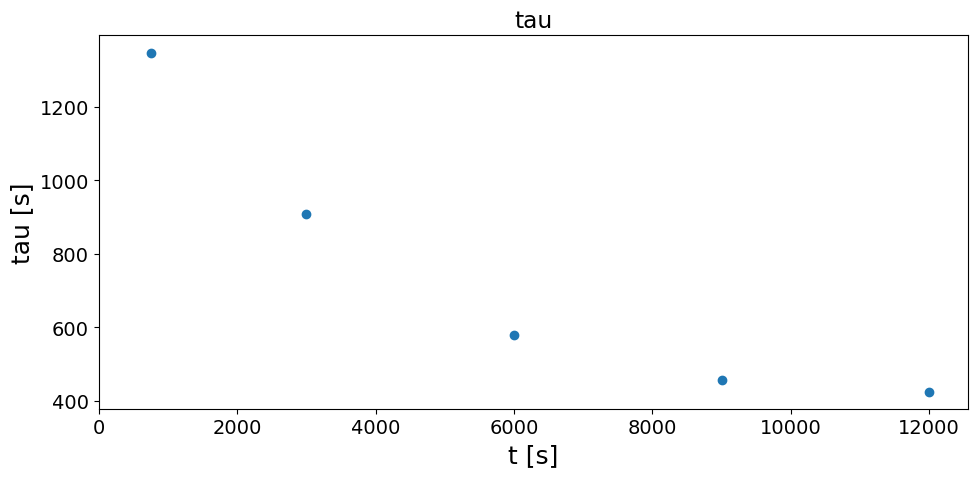

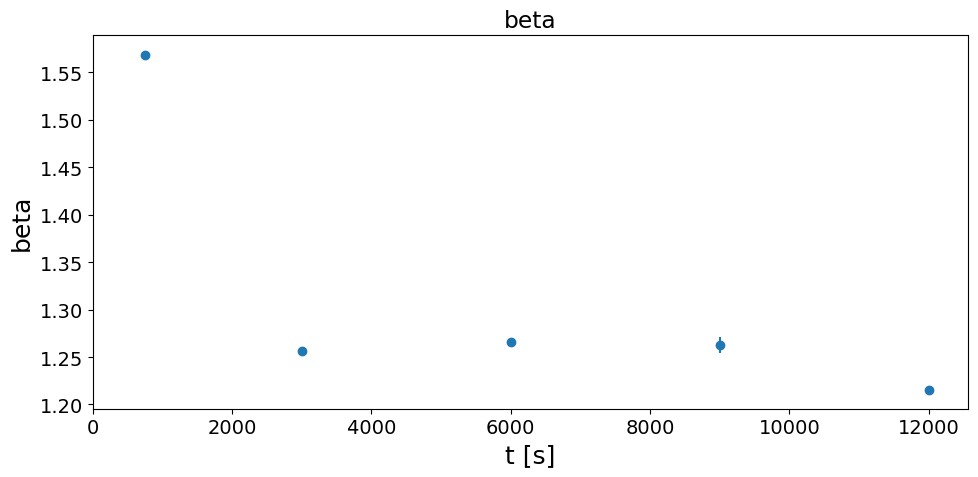

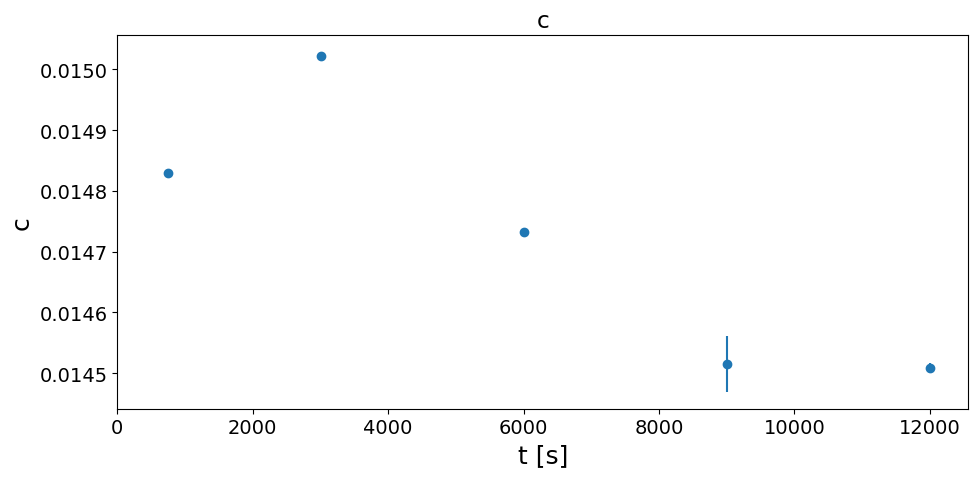

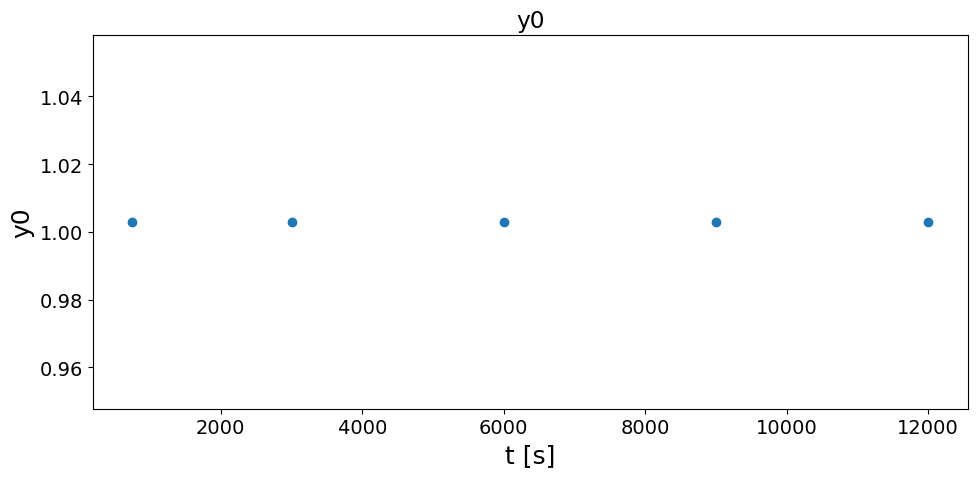

In [82]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00289555, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=10, T=16h (Ta2O5_2.5um_asdep, 1, 6)  

Tantala as deposited

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  15.822294583333335 h
theta = 10.384625
Qc = 1.99
#############################



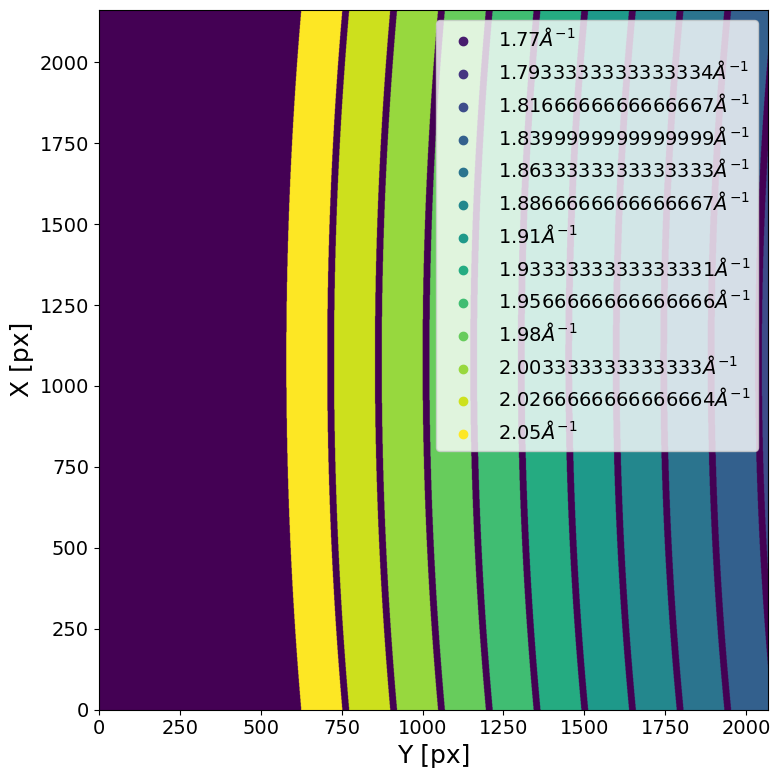

TypeError: unsupported operand type(s) for *: 'bool' and 'dict'

In [174]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 1
Nscan = 6
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6)
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################

#e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=10, )

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  2854900 pixels (of 4471016 => 63.85 %)
# of pixels below Ith_low treshold ->  1528 pixels (of 4471016 => 0.03 %)
################################################################################



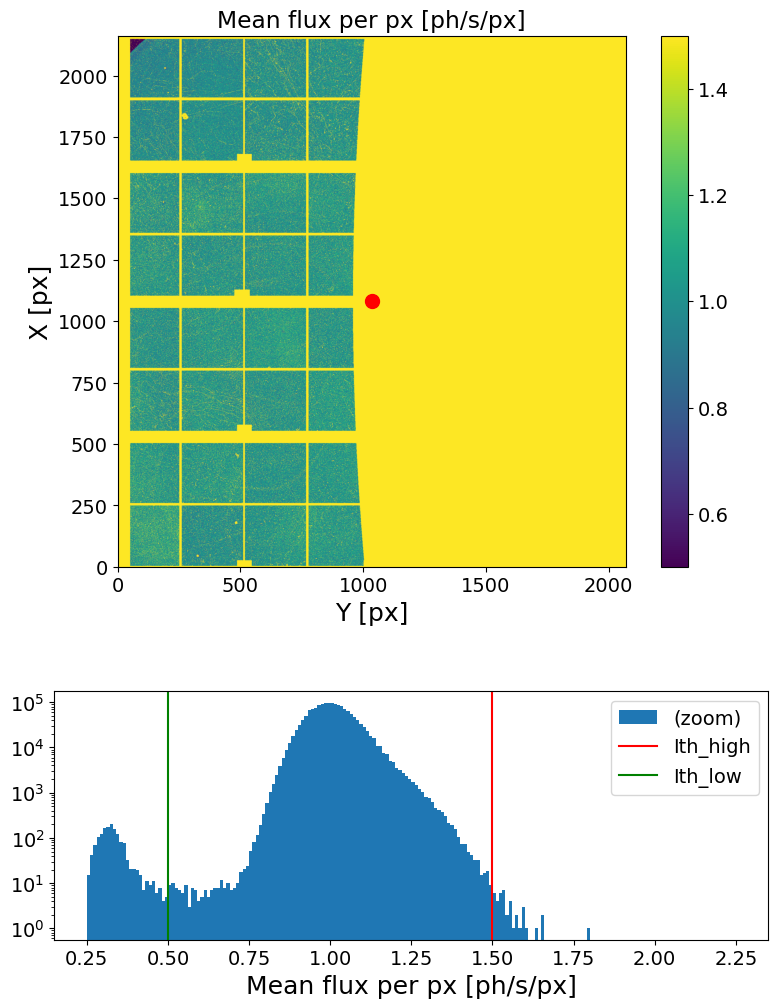

In [13]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=0.5, Ith_high=1.5, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [14]:
####################
Lbin = 100
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

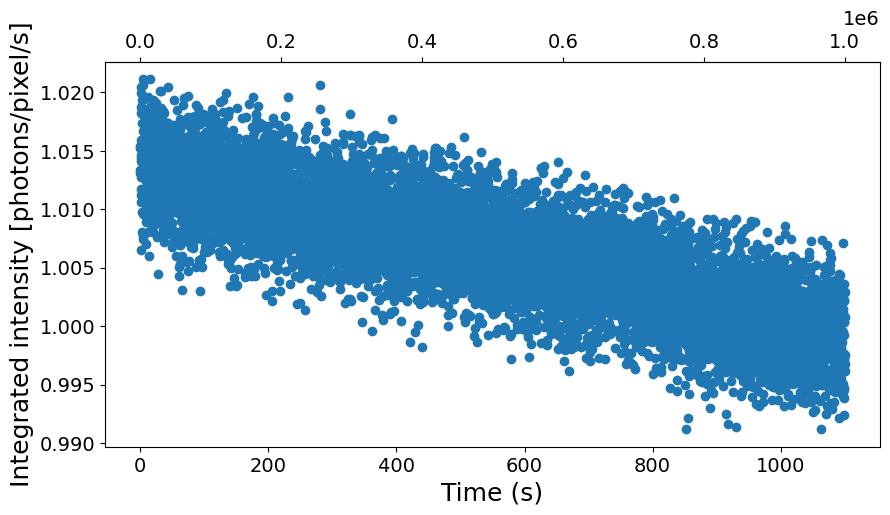

Exception ignored in: <function ResourceTracker.__del__ at 0x79615d397ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x753d50777ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Pilatus

In [15]:
#######################################
Nstep = 1000
#######################################

#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 3
Nscan = 9
#######################################
pilatus_data = ID10.load_pilatus(RAW_folder, sample_name, Ndataset, Nscan, Nfi=None, Nff=None, Nstep=Nstep)
qA, SqA, dSqA = XPCS.get_Sq(pilatus_data, ponifile=pilatus_LaB6_poni, mask=pilatus_mask, npt=100)
SqA = SqA/SqA[:,(qA<2)*(qA>1.8)].max(axis=1)[:,None]
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 1
Nscan = 6
#######################################
pilatus_data = ID10.load_pilatus(RAW_folder, sample_name, Ndataset, Nscan, Nfi=None, Nff=None, Nstep=Nstep)
qB, SqB, dSqB = XPCS.get_Sq(pilatus_data, ponifile=pilatus_LaB6_poni, mask=pilatus_mask, npt=100)
SqB = SqB/SqB[:,(qB<2)*(qB>1.8)].max(axis=1)[:,None]



Computing azimuthal integration...


100%|██████████| 12/12 [00:00<00:00, 63.72it/s]

Done! (elapsed time = 0.19 s)


Computing azimuthal integration...


  7%|▋         | 2/29 [00:00<00:01, 19.81it/s]

100%|██████████| 29/29 [00:00<00:00, 85.73it/s]

Done! (elapsed time = 0.34 s)


(1.8, 2.5)

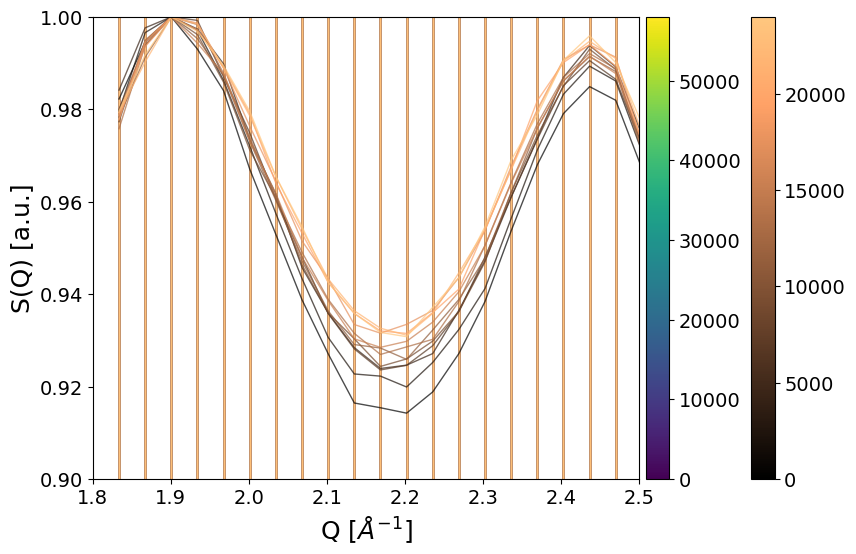

In [22]:
itime_4cbar=2
alpha=0.7
lw=1
import matplotlib.cm as cm


fig, ax = plt.subplots(figsize=(10, 6))
cmap=cm.copper
colors = cmap(np.linspace(0, 1, SqA.shape[0]))
for i in range(len(SqA)):
    if dSqA is None: ax.plot(qA, SqA[i], color=colors[i], alpha=alpha, lw=lw)
    else: ax.errorbar(qA, SqA[i], yerr=dSqA[i], color=colors[i], alpha=alpha, lw=lw)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=SqA.shape[0]*itime_4cbar*Nstep)), ax=ax, pad=0.01)
cmap=cm.viridis
colors = cmap(np.linspace(0, 1, SqB.shape[0]))
for i in range(len(SqB)):
    if dSqB is None: ax.plot(qB, SqB[i], color=colors[i], alpha=alpha, lw=lw)
    else: pass#ax.errorbar(qB, SqB[i], yerr=dSqB[i], color=colors[i], alpha=alpha, lw=lw)


ax.set_xlabel("Q [$\\AA^{-1}$]"); ax.set_ylabel("S(Q) [a.u.]")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=SqB.shape[0]*itime_4cbar*Nstep)), ax=ax, pad=0.01)


plt.ylim(.9,1)
plt.xlim(1.8, 2.5)


### Linear correlation 4 tests

In [9]:
###################
Nfi = None
Nff = int(1e7)
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 20.41 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 4.29 s)
	 | 10000 frames X 211221 pixels
	 | memory usage (np.array @ float32) = 7.869 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 5.0 s)
	 | 10000 X 10000 squared matrix
	 | memory usage (np.array @ float32) = 0.373 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.37 s)



In [10]:
############################
t1, t2 = 0, 15000
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [11]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.07 s)



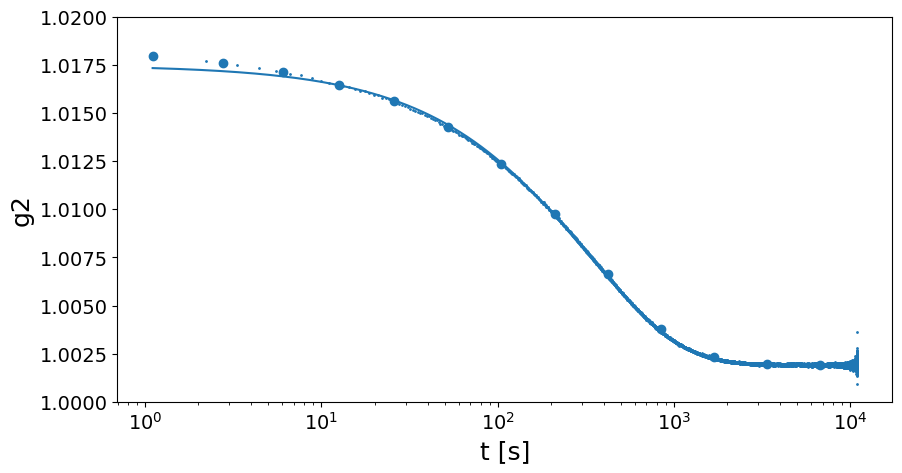

Parameters([('tau', <Parameter 'tau', value=np.float64(326.54880114010234) +/- 0.251, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(0.8220277096705724) +/- 0.000537, bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(0.015551875043490945) +/- 6.64e-06, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.0019287350939134) +/- 4.65e-07, bounds=[0:2]>)])

In [12]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')
    
    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.02)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [13]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 51782290  =>  t_ff = 56960.519
#############################



In [7]:
########################################
#N_segments = 5
t_segments = [0, 50, 200, 500, 1000]#[0, 1.5e3, 5e3, 9e3, 15e3, 23e3, 32e3, 42e3, 56e3] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [8]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

  0%|          | 0/4 [00:00<?, ?it/s]/gpfs/jazzy/data/visitor/hc6211/id10-coh/20250527/SCRIPTS_Trento/XPCSlibrary/XPCS_tools.py:827: RuntimeWarning: invalid value encountered in sqrt
  if    G2t.dtype==np.float32: g2, dg2 = mean_trace_float32(G2t)
100%|██████████| 4/4 [01:21<00:00, 20.45s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

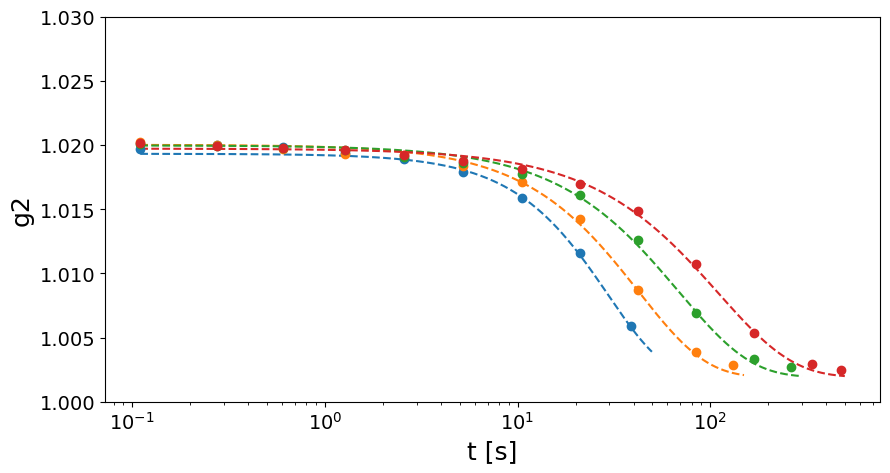

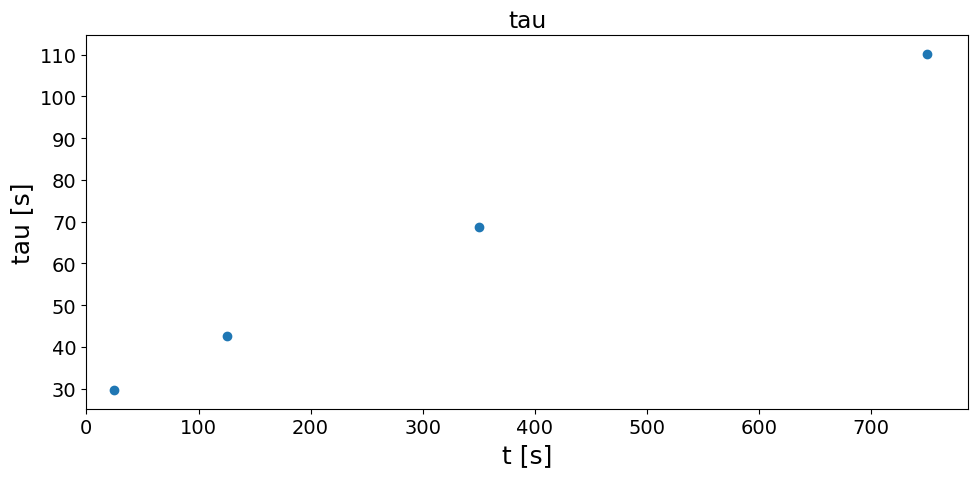

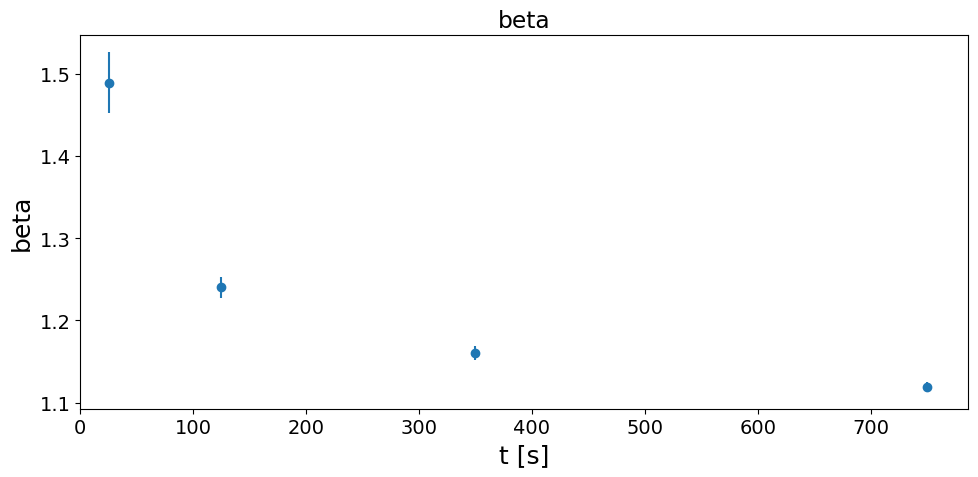

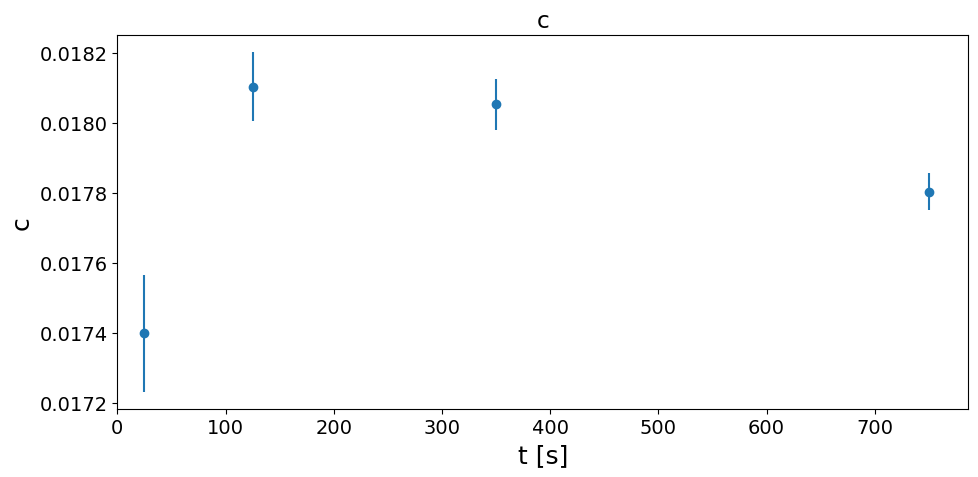

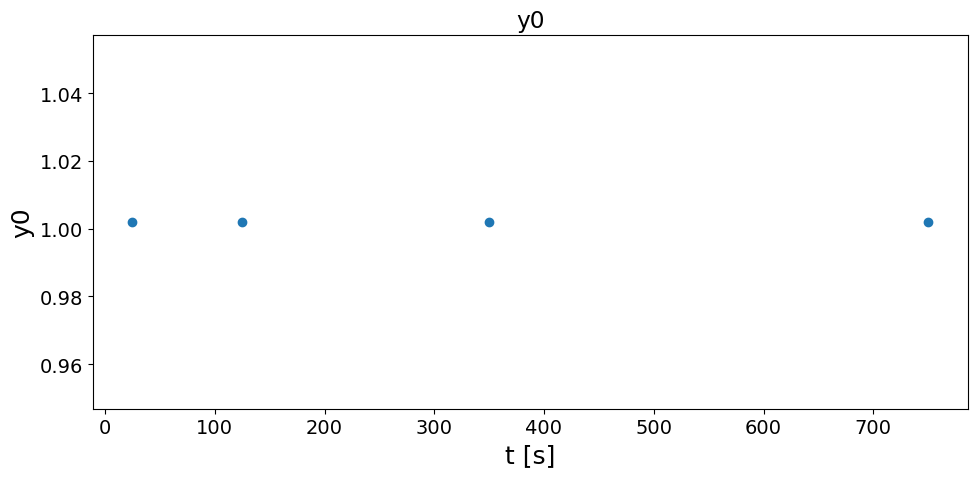

In [9]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00192874, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = 0.01#dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=10, T=20min (Ta2O5_2.5um_asdep, 2, 9)  

Verifica di riavere il contrasto di prima!

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  0.1930775 h
theta = 10.4
Qc = 1.99
#############################



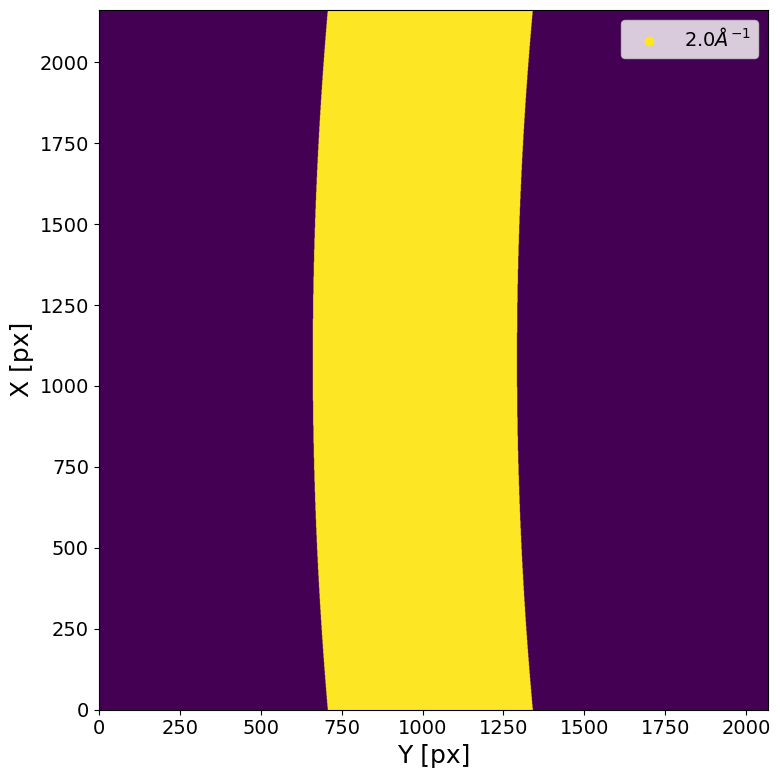

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00023.h5 (24/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00041.h5 (42/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00012.h5 (13/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00030.h5 (31/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00014.h5 (15/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00039.h5 (40/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00021.h5 (22/127 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00046.h5 (47/127 loops)
	 -> loading file eiger4m_v2_

In [68]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 2
Nscan = 9
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, None
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  3392768 pixels (of 4471016 => 75.88 %)
# of pixels below Ith_low treshold ->  4 pixels (of 4471016 => 0.0 %)
################################################################################



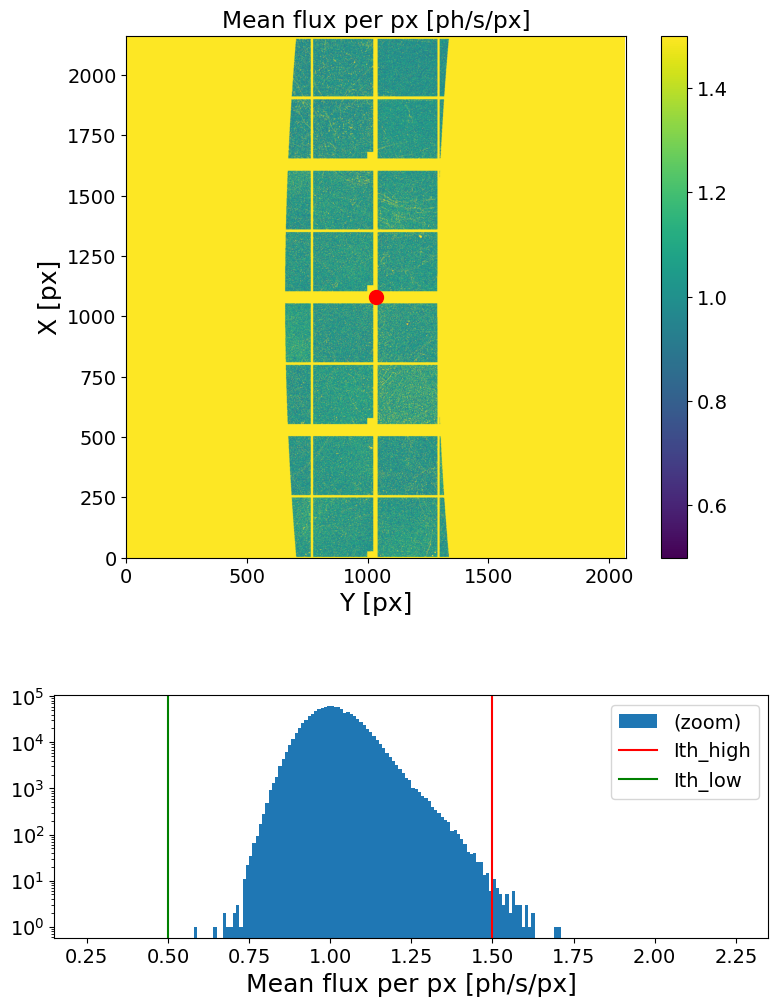

In [69]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.5, Ith_high=1.5, Nfi=None, Nff=int(1e6), load_mask=load_mask, mask=None)

### Intensity analysis

In [70]:
####################
Lbin = 100
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

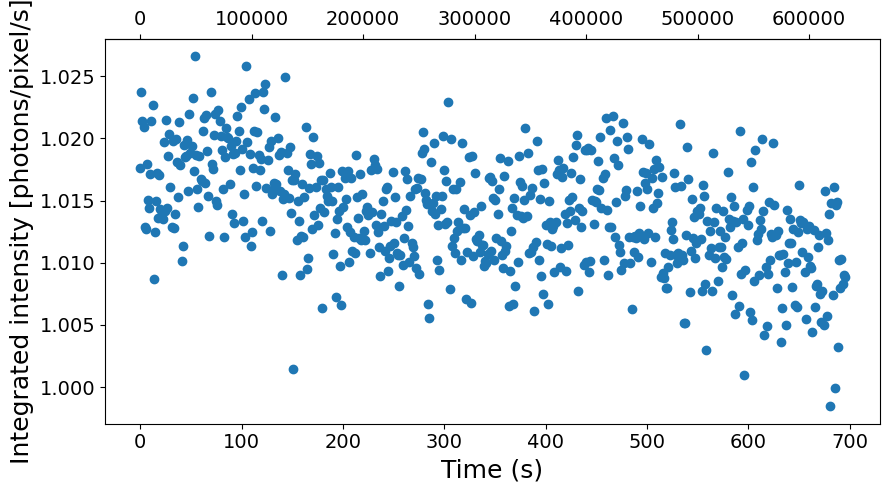

In [71]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [9]:
###################
Nfi = None
Nff = int(1e7)
Lbin = 1000
bin2dense = False
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.17 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 1.8 s)
	 | 632 frames X 195702 pixels
	 | sparsity = 6.66e-01
	 | memory usage (sparse.csr_array @ float32) = 0.92 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 6.52 s)
	 | 632 X 632 squared matrix
	 | memory usage (np.array @ float32) = 0.001 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.02 s)



In [10]:
############################
t1, t2 = 0, 15000
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [11]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



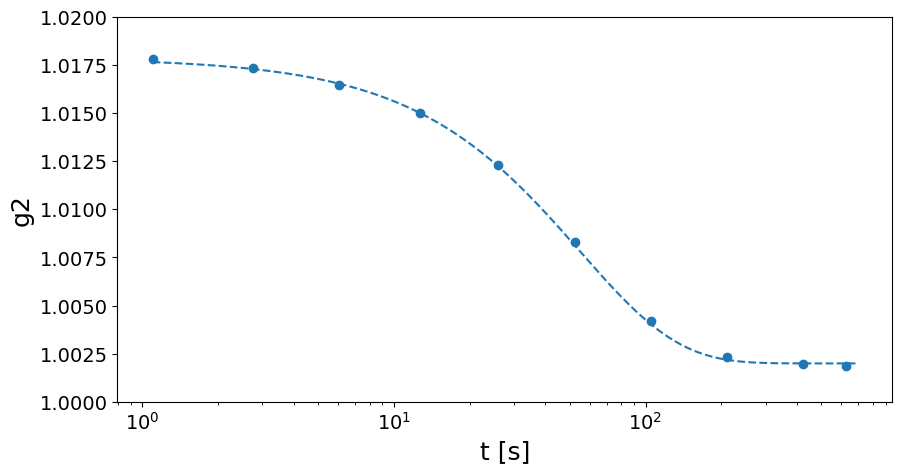

Parameters([('tau', <Parameter 'tau', value=np.float64(54.76399771413889) +/- 0.249, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(1.106126643214611) +/- 0.00665, bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(0.015863732663420203) +/- 4.71e-05, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.001995061599476) +/- 7.3e-06, bounds=[0:2]>)])

In [14]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.02)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

## XPCS scan: delcoup=10, T=20min (Ta2O5_2.5um_asdep, 4, 1)  

Misura dopo cambio soglia!

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  0.21831272222222226 h
theta = 10.4
Qc = 1.99
#############################



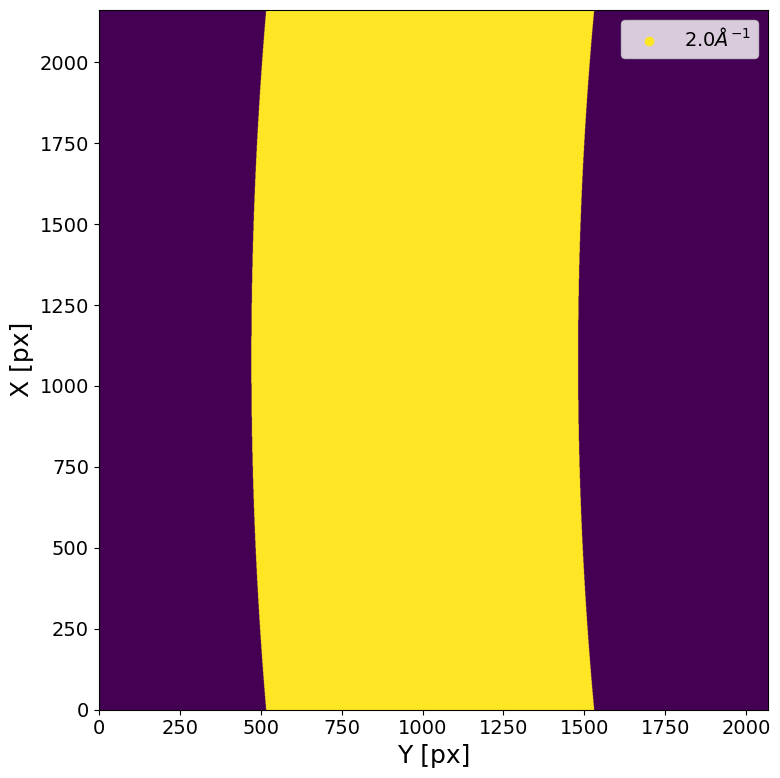

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00012.h5 (13/143 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00013.h5 (14/143 loops)
	 -> loading file eiger4m_v2_spa

In [9]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 4
Nscan = 1
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, None
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 4.0
# of pixels above Ith_high treshold ->  2729492 pixels (of 4471016 => 61.05 %)
################################################################################



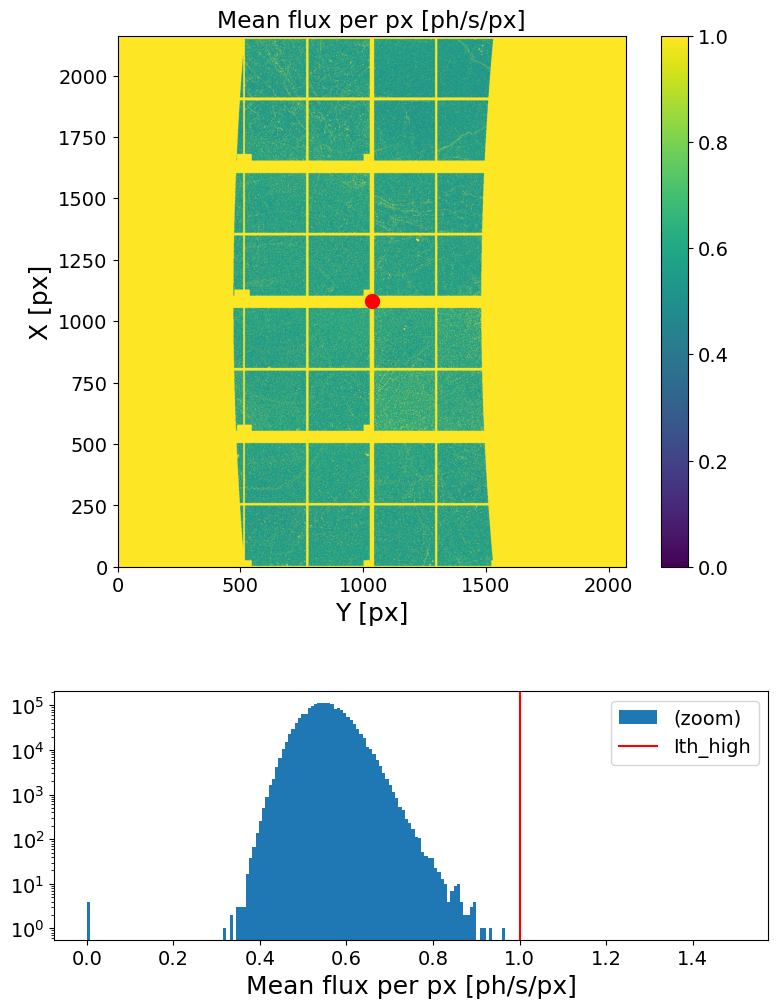

In [10]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [11]:
####################
Lbin = 100
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

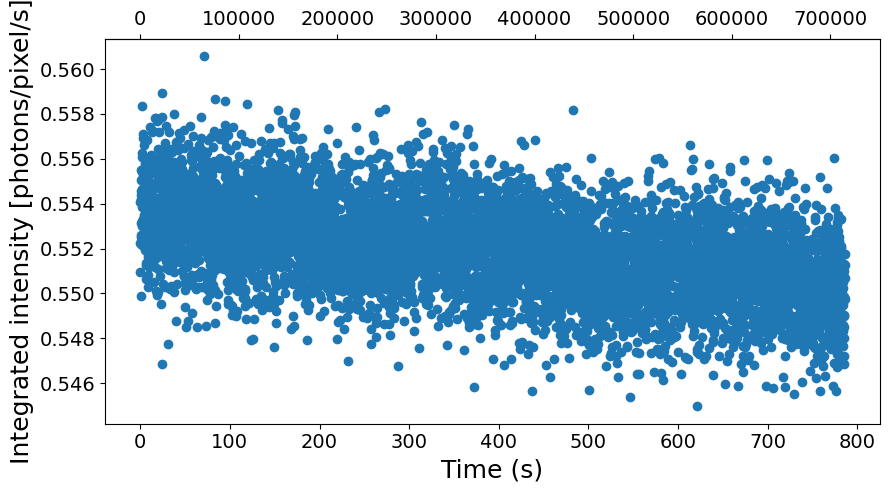

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [68]:
###################
Nfi = None
Nff = int(100e3)
Lbin = 100
bin2dense = False
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...


Done! (elapsed time = 0.95 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 0.85 s)
	 | 1000 frames X 1741524 pixels
	 | sparsity = 5.90e-02
	 | memory usage (sparse.csr_array @ float32) = 1.149 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 5.57 s)
	 | 1000 X 1000 squared matrix
	 | memory usage (np.array @ float32) = 0.004 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.02 s)



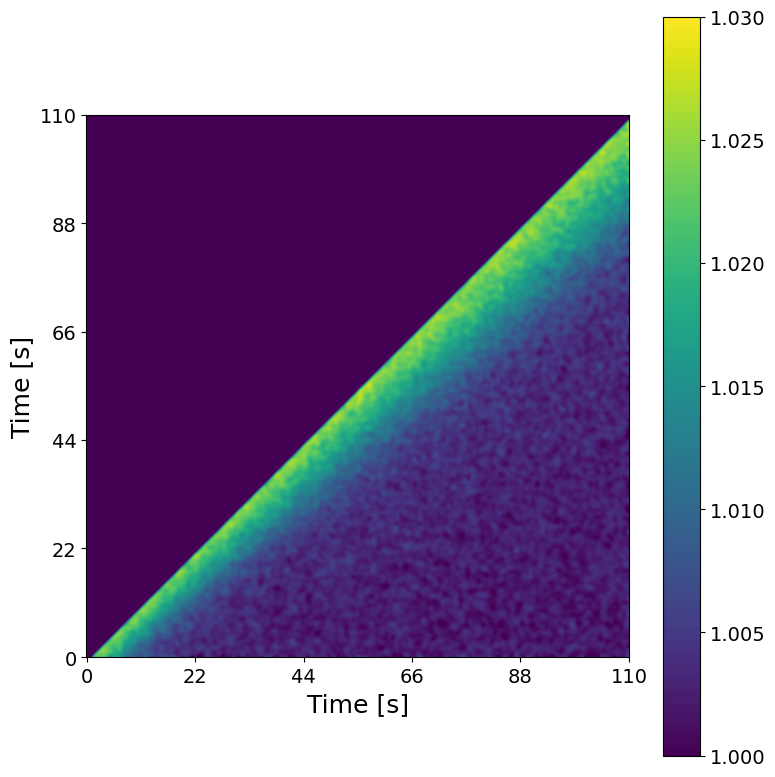

In [69]:
############################
t1, t2 = 0, None
vmin, vmax = 1.0, 1.03
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=4)

In [73]:
################
Nbunch = 5
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



In [79]:
150*50*5/3600 + 7

17.416666666666664

/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

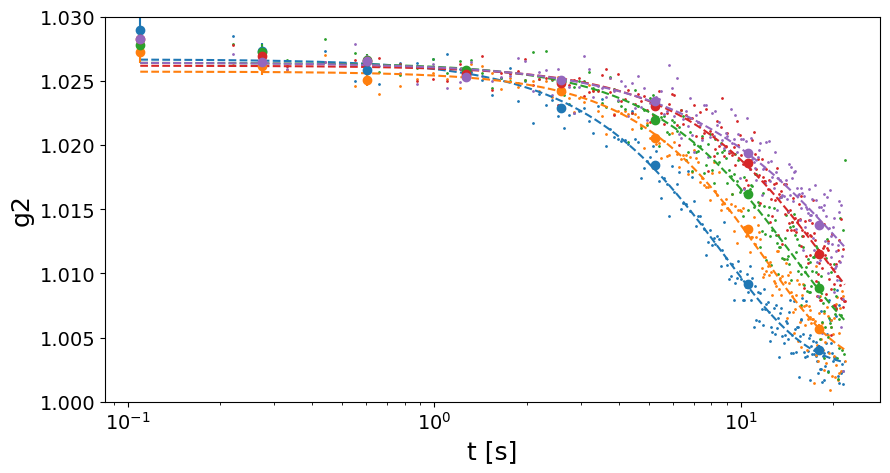

Q    dQ        tau      beta         c        y0      dtau     dbeta  \
t                                                                              
11.0  2.0  0.08   8.728788  1.586930  0.023942  1.002746  0.117789  0.053033   
33.0  2.0  0.08  11.916832  1.741195  0.022985  1.002746  0.127648  0.054489   
55.0  2.0  0.08  14.694795  1.609653  0.023673  1.002746  0.228489  0.072748   
77.0  2.0  0.08  18.456680  1.594270  0.023447  1.002746  0.314079  0.071926   
99.0  2.0  0.08  22.936941  1.325386  0.023687  1.002746  1.004240  0.118895   

            dc  dy0  
t                    
11.0  0.000286  0.0  
33.0  0.000213  0.0  
55.0  0.000276  0.0  
77.0  0.000222  0.0  
99.0  0.000401  0.0

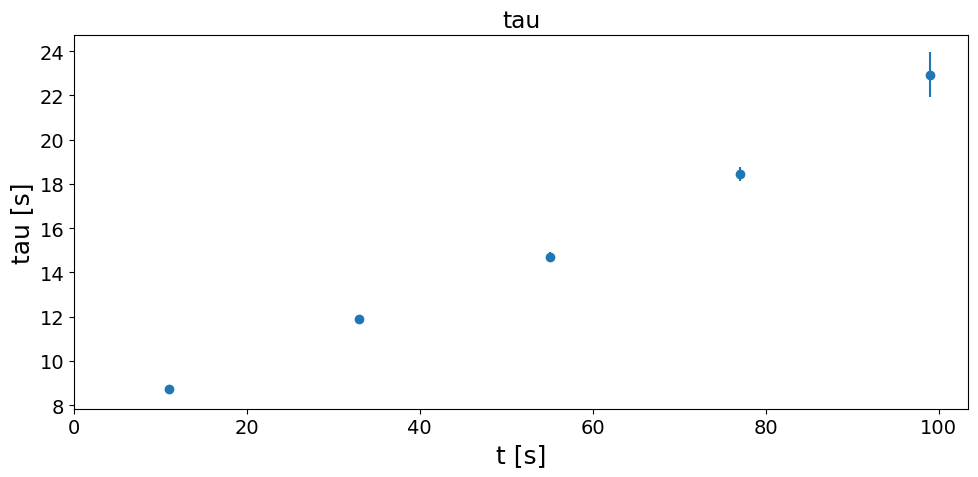

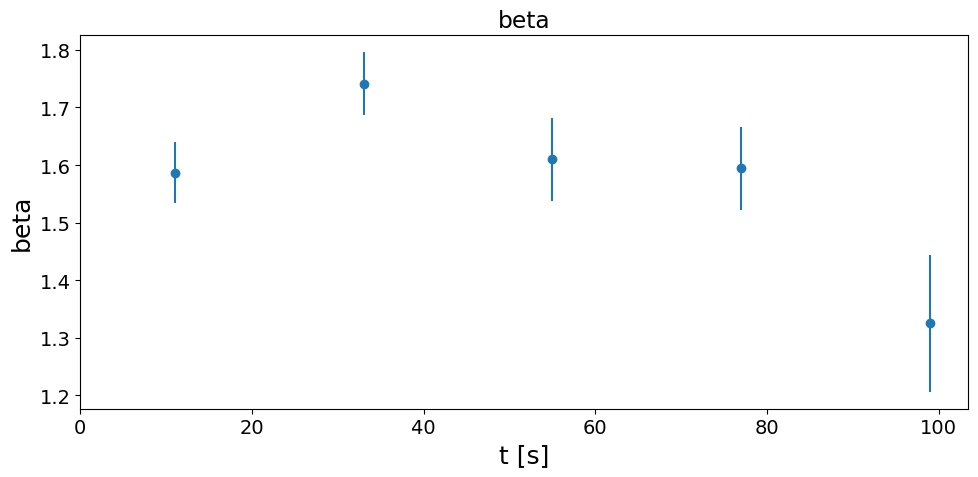

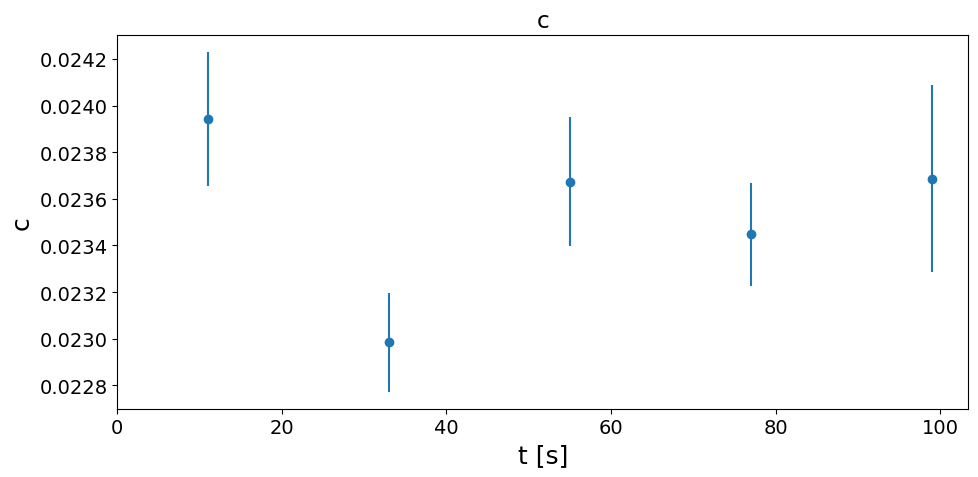

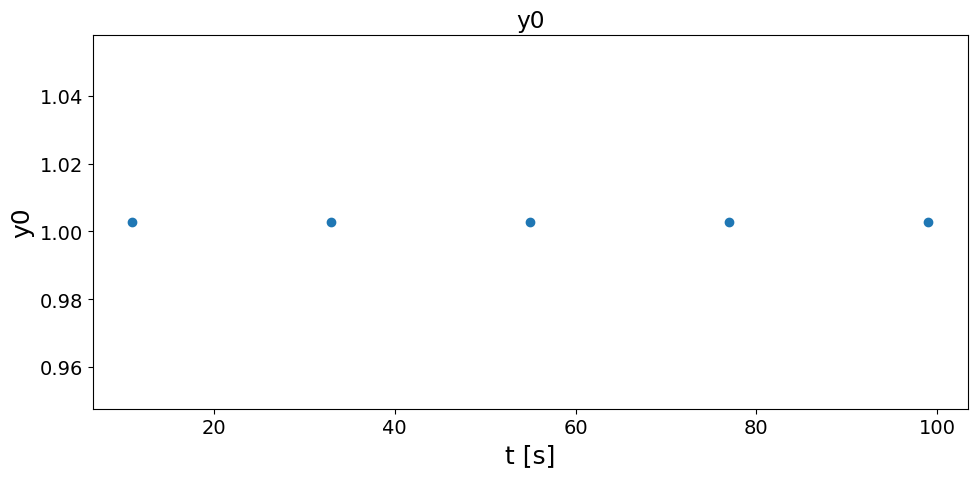

In [74]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=10, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00274588, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    display(g2_fit)
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    #plt.ylim(0,30)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [14]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 714657  =>  t_ff = 786.1227
#############################



In [21]:
########################################
#N_segments = 5
#t_segments = [0, 20, 60, 130, 350, 786] #np.linspace(0, int(t_ff), N_segments)
t_segments = [0, 50, 200, 500, 786]#, 786]
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [22]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 4/4 [00:31<00:00,  7.95s/it]


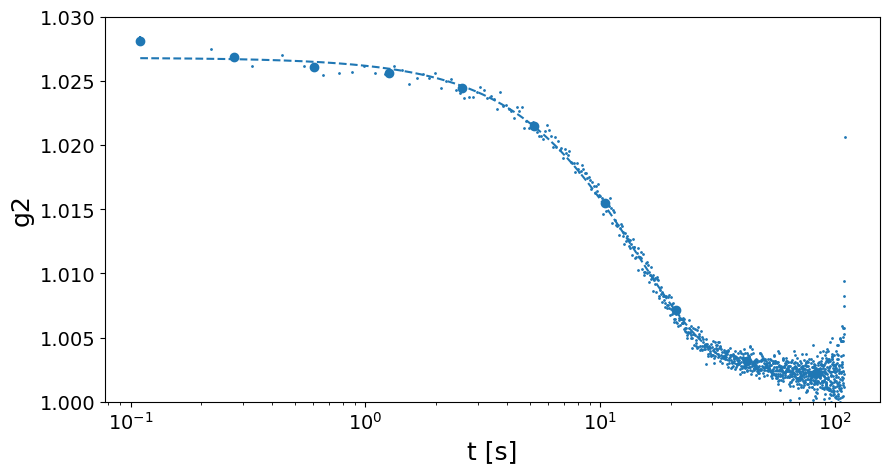

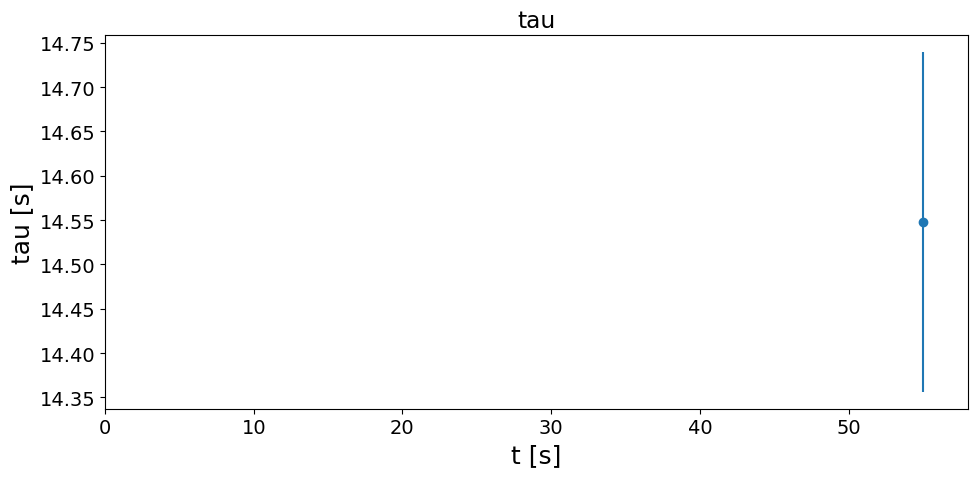

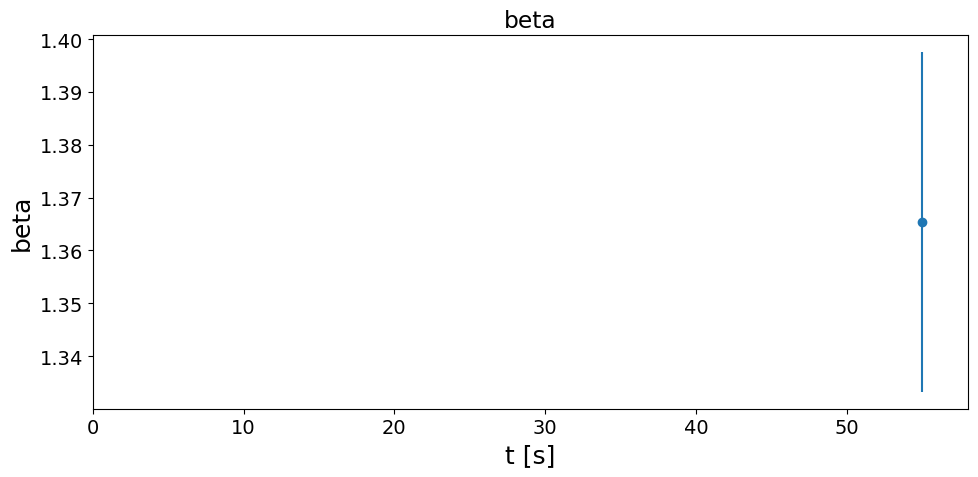

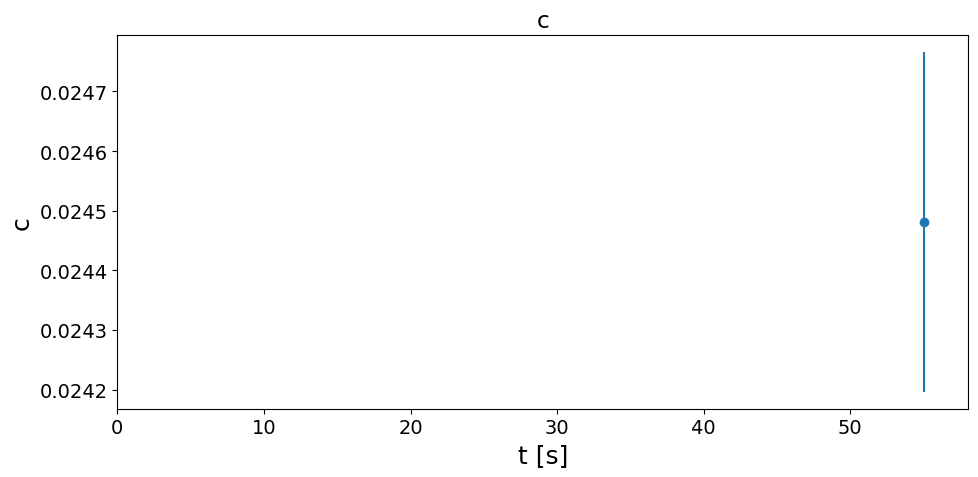

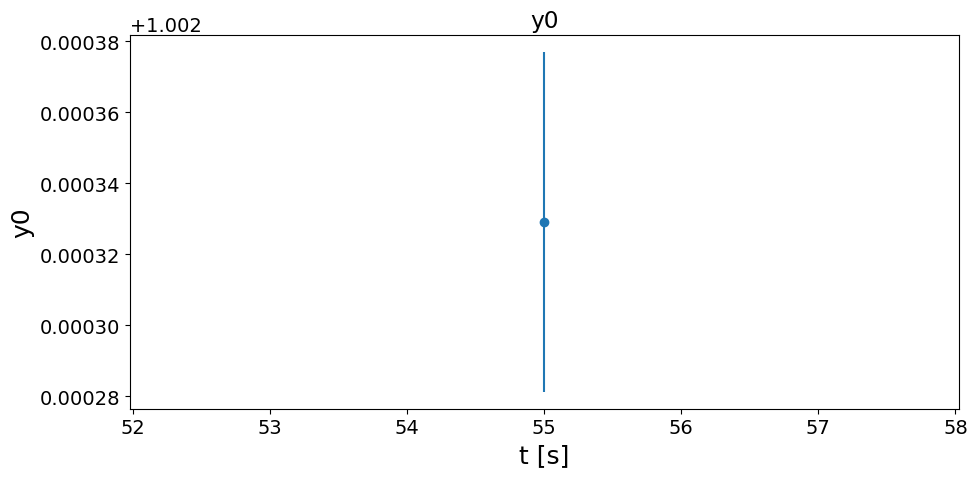

In [72]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.00183841, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = 0.001#dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=10, T=20min (Ta2O5_2.5um_asdep, 4, 13)  

Misura con attenuatore 0.5

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  0.37146022222222225 h
theta = 10.38
Qc = 1.99
#############################



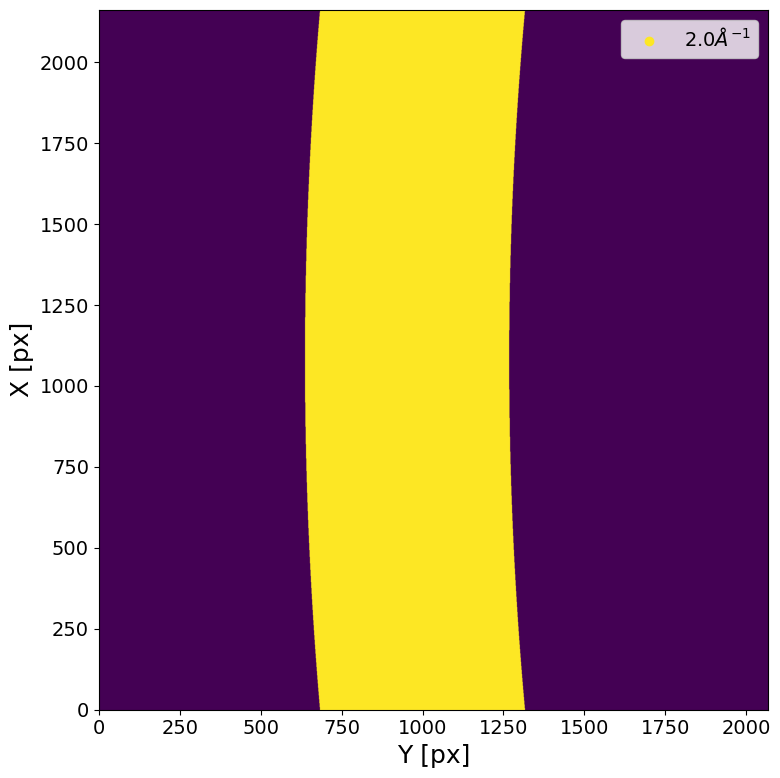

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00013.h5 (14/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/243 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00015.h5 (16/243 loops)
	 -> loading file eiger4m_v2_spa

In [9]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 4
Nscan = 13
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, len(scan['fast_timer_period'])-5001
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 3.0
# of pixels above Ith_high treshold ->  3385541 pixels (of 4471016 => 75.72 %)
################################################################################



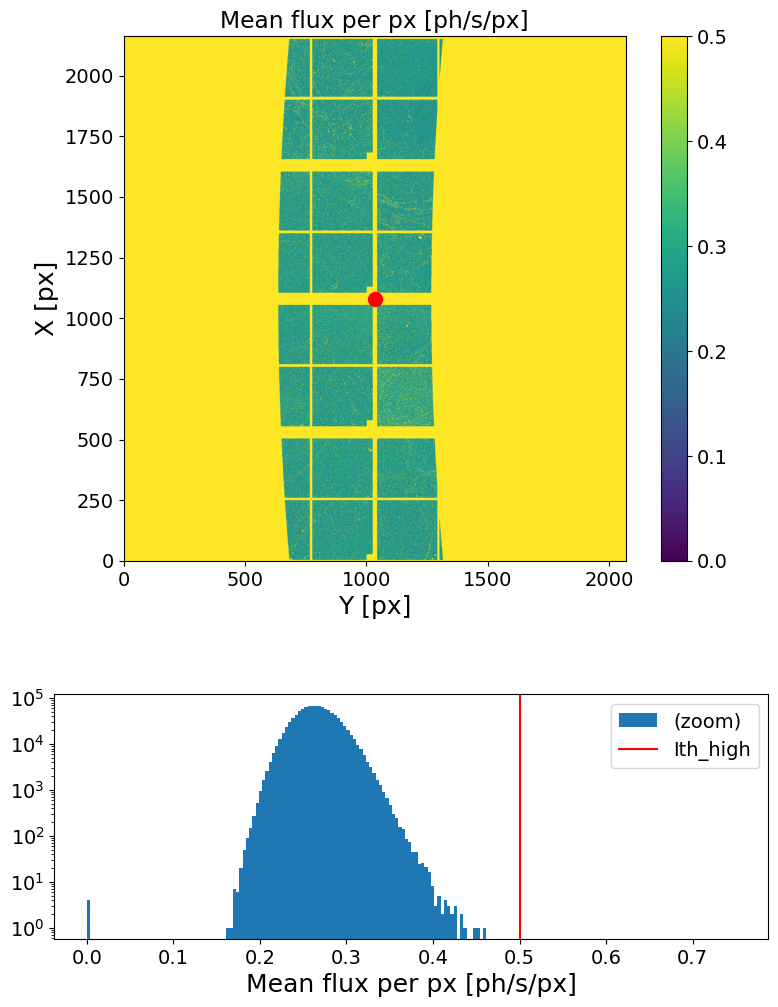

In [11]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.5, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [12]:
####################
Lbin = 100
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

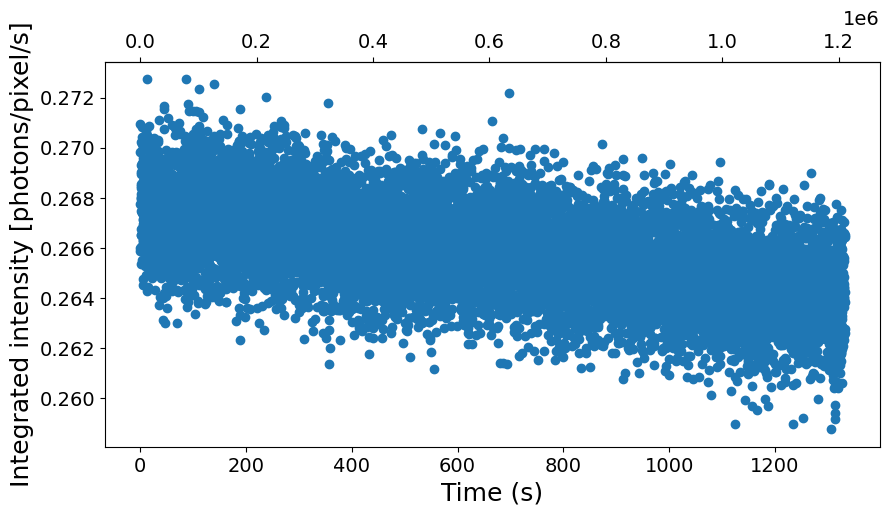

In [13]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [14]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = False
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...


Done! (elapsed time = 3.53 s)
	 | 1210 frames X 1085475 pixels
	 | sparsity = 2.53e-01
	 | memory usage (sparse.csr_array @ float32) = 3.709 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 20.75 s)
	 | 1210 X 1210 squared matrix
	 | memory usage (np.array @ float32) = 0.005 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.35 s)



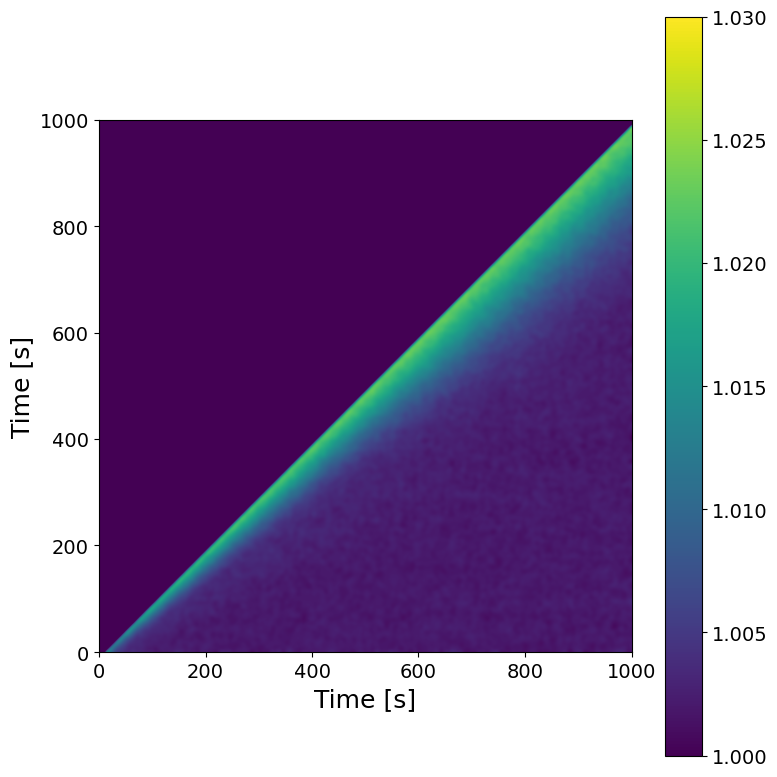

In [16]:
############################
t1, t2 = 0, 1000
vmin, vmax = 1.0, 1.03
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=4)

In [17]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



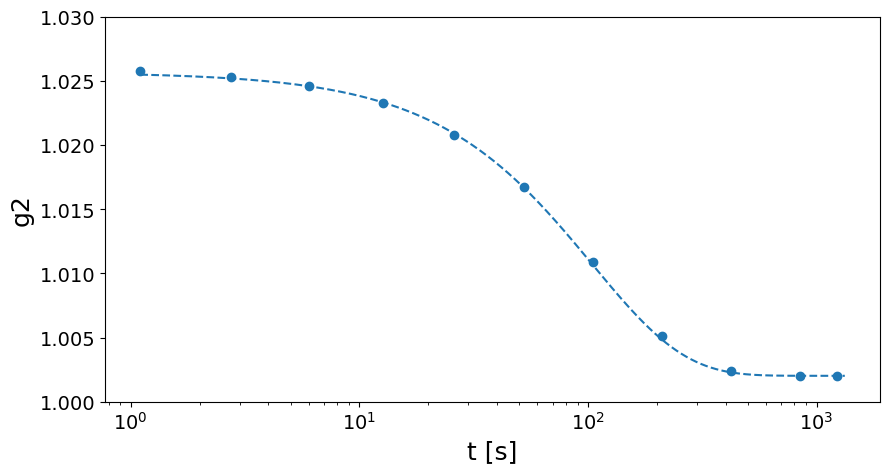

Parameters([('tau', <Parameter 'tau', value=np.float64(104.30187992244561) +/- 0.254, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(1.0724361567565934) +/- 0.00335, bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(0.023647512654942044) +/- 3.67e-05, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.0020269630918848) +/- 5.7e-06, bounds=[0:2]>)])

In [18]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [19]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 1210687  =>  t_ff = 1331.7557000000002
#############################



In [20]:
########################################
#N_segments = 5
t_segments = [0, 20, 60, 130, 350, 786] #np.linspace(0, int(t_ff), N_segments)
#t_segments = [0, 5, 10, 15, 40, 70, 100, 300]#, 786]
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [21]:
###################
Lbin = 10
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

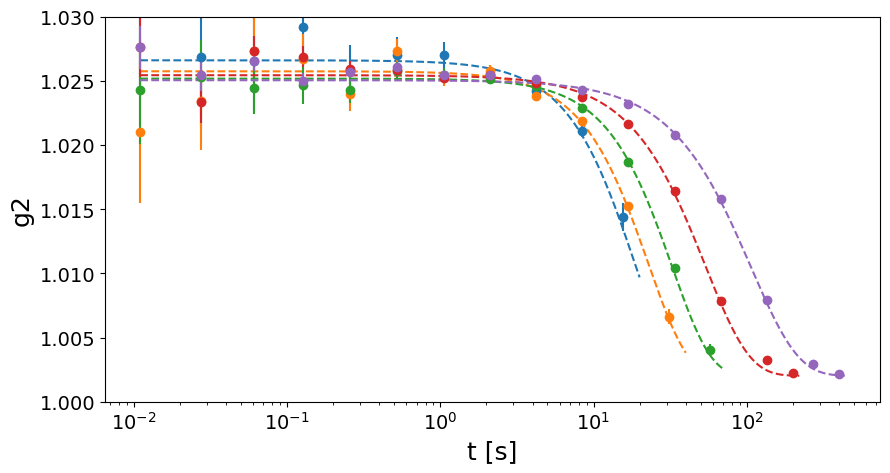

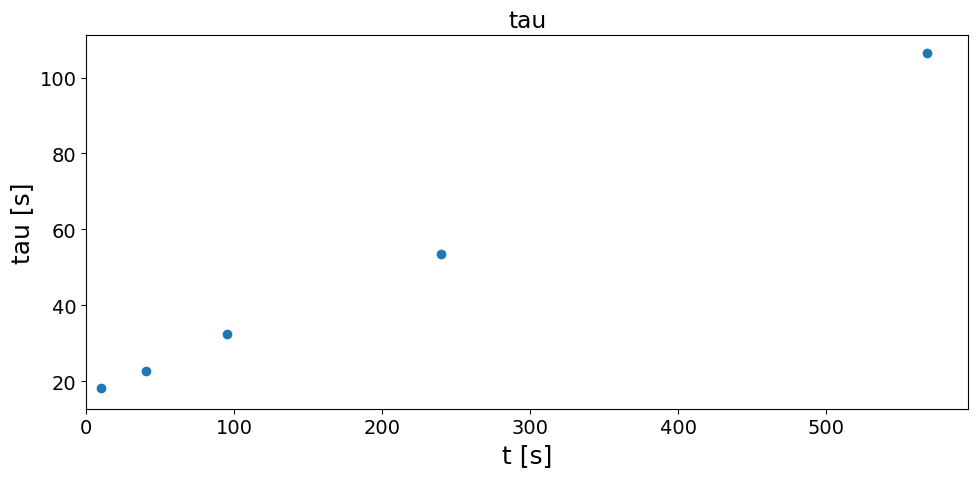

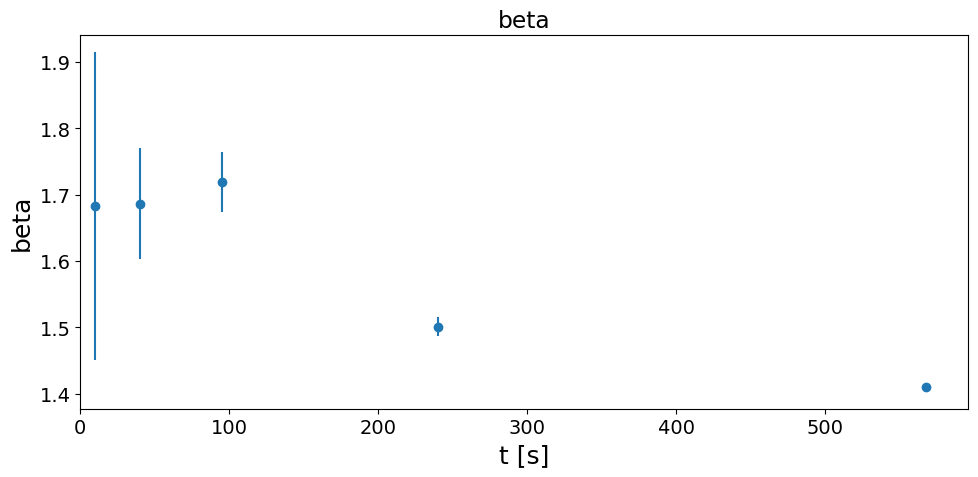

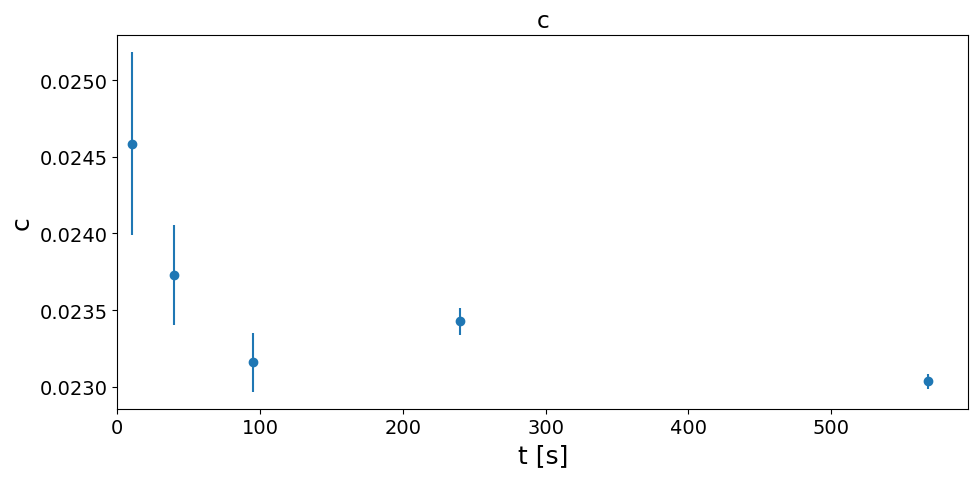

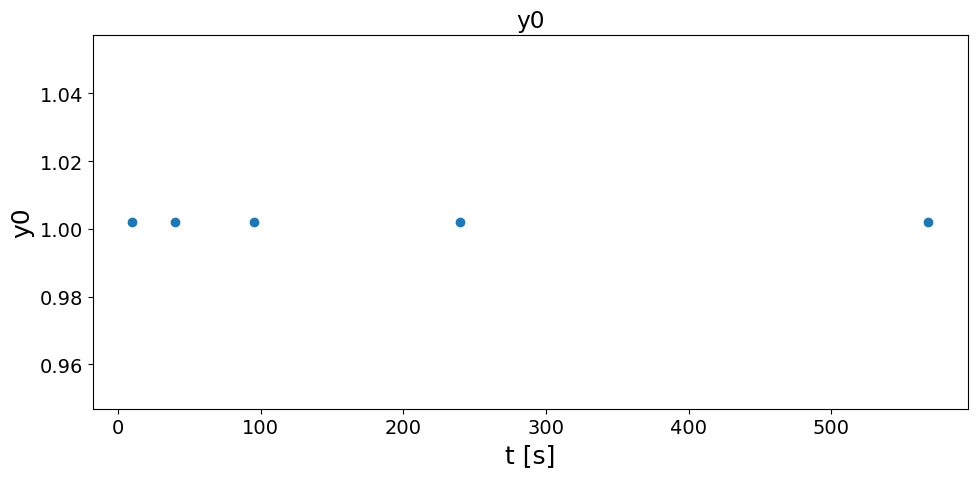

Exception ignored in: <function ResourceTracker.__del__ at 0x7f34323bbba0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fac1cf33ba0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [23]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00202696, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=10, T=30min (Ta2O5_2.5um_AsDep_B, 1, 54)  

Misura per trovare la baseline della mesh

#############################
command = mtimescan 0.001 1 1500240
Ei = 21.669991317784486
itime = 0.0011
T =  0.4584066666666667 h
theta = 10.4
Qc = 1.99
#############################



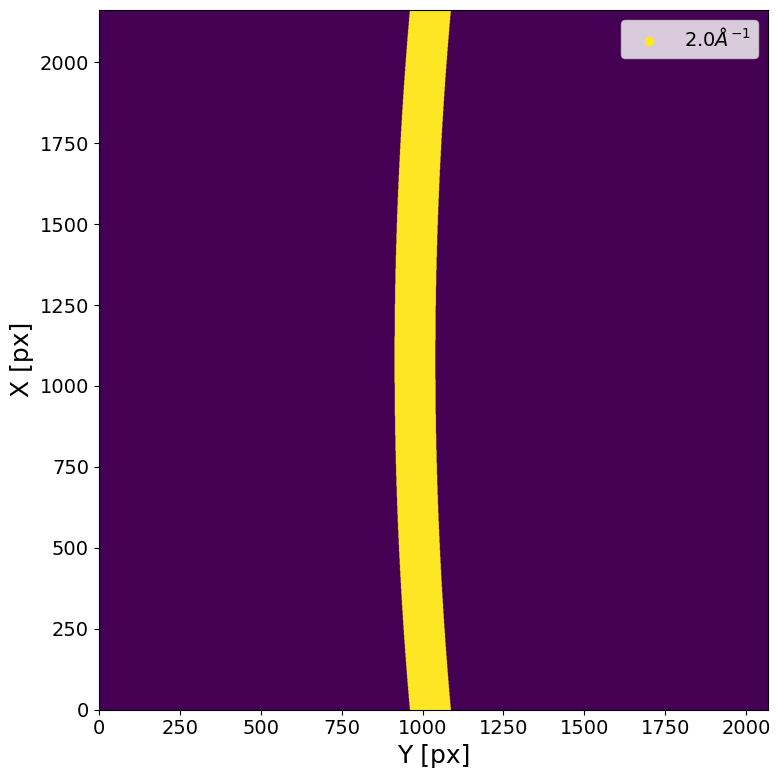

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00058.h5 (59/300 loops)
	 -> loading file eiger4m_v2

Exception ignored in: <function ResourceTracker.__del__ at 0x799f80647ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x758838297ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [107]:
#######################################
sample_name = 'Ta2O5_2.5um_AsDep_B'
Ndataset = 1
Nscan = 54
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, len(scan['fast_timer_period'])-5001
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 3.0
# of pixels above Ith_high treshold ->  4275344 pixels (of 4471016 => 95.62 %)
################################################################################



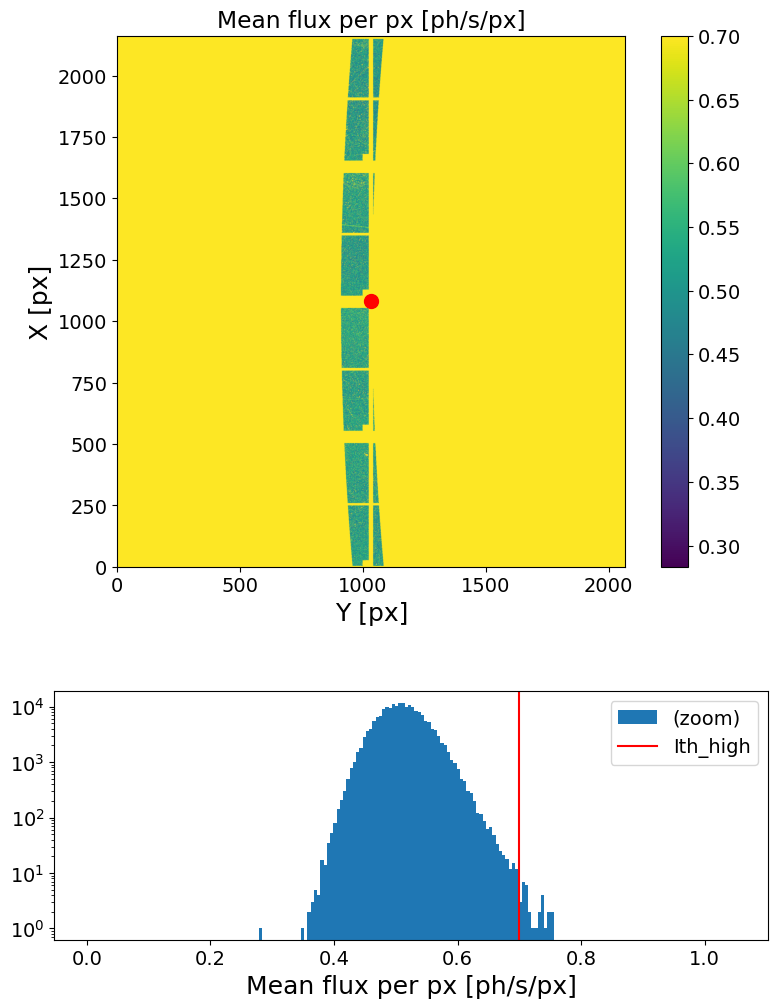

In [109]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.7, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [110]:
####################
Lbin = 100
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

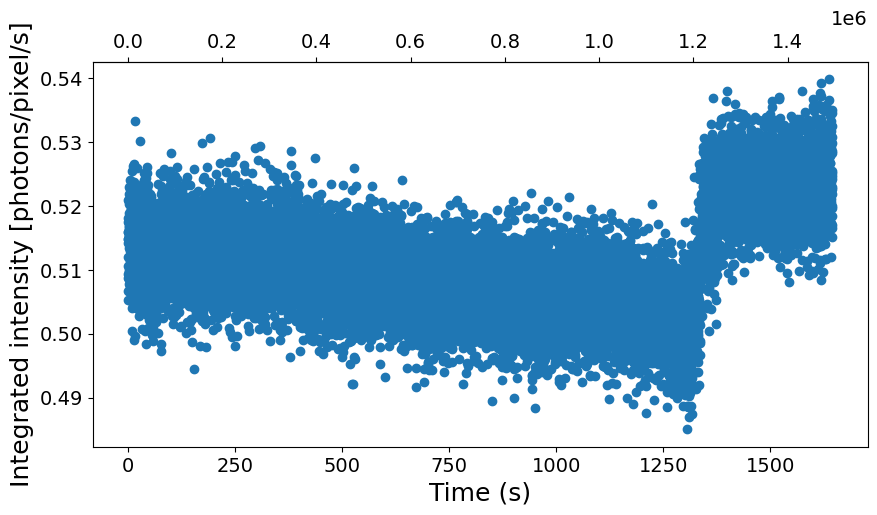

In [111]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [112]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 1.51 s)
	 | 1495 frames X 195702 pixels
	 | memory usage (np.array @ float32) = 1.09 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 0.27 s)
	 | 1495 X 1495 squared matrix
	 | memory usage (np.array @ float32) = 0.008 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.05 s)



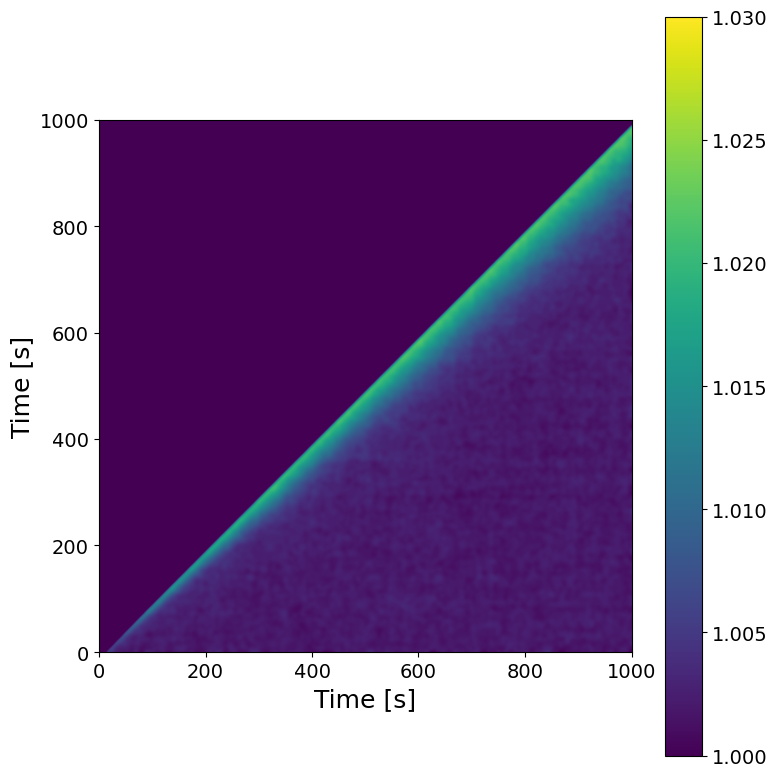

In [113]:
############################
t1, t2 = 0, 1000
vmin, vmax = 1.0, 1.03
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=4)

In [114]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



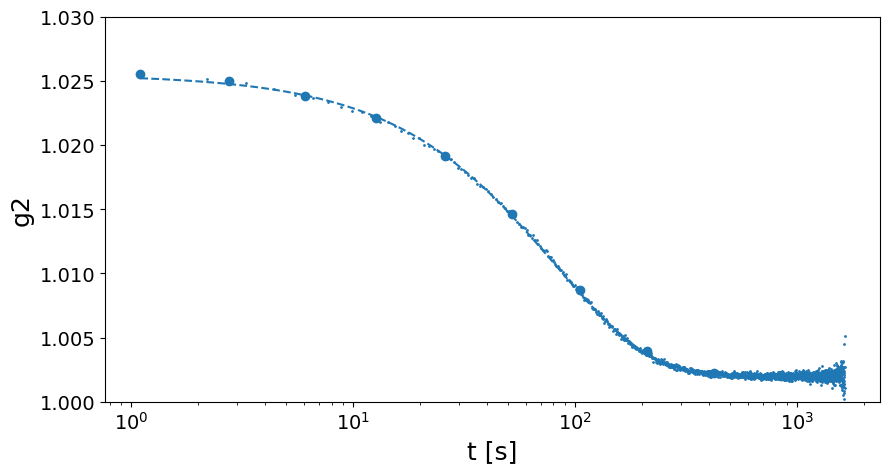

Parameters([('tau', <Parameter 'tau', value=np.float64(81.51922603777777) +/- 0.261, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(1.013389081430944) +/- 0.00377, bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(0.02348894314483901) +/- 4.87e-05, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.0020264385233988) +/- 5.16e-06, bounds=[0:2]>)])

In [116]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

## XPCS scan: delcoup=10, T=20min (Ta2O5_2.5um_AsDep_B, 1, 4-53)  

Mesh

#############################
command = mtimescan 0.001 1 20064
Ei = 21.669991317784486
itime = 0.0011
T =  0.006130666666666667 h
theta = 10.4
Qc = 1.99
#############################



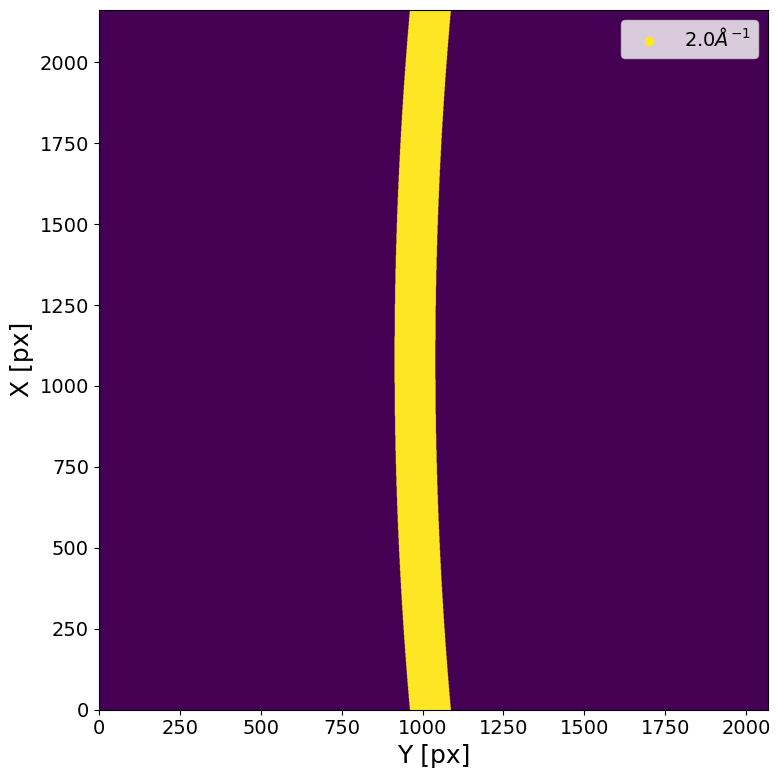

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


In [5]:
#######################################
sample_name = 'Ta2O5_2.5um_AsDep_B'
Ndataset = 1
Nscan = range(4, 54)
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan[0])
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################

e4m_data = []
for n in tqdm(Nscan):
    with redirect_stdout(io.StringIO()):
        e4m_data.append(ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, n, Nfi=None, Nff=None, load_mask=load_mask, n_jobs=1, ))


### Flux check

In [118]:
#XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.5, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [119]:
####################
Lbin = 1
Nstep = 1
mask = None
####################

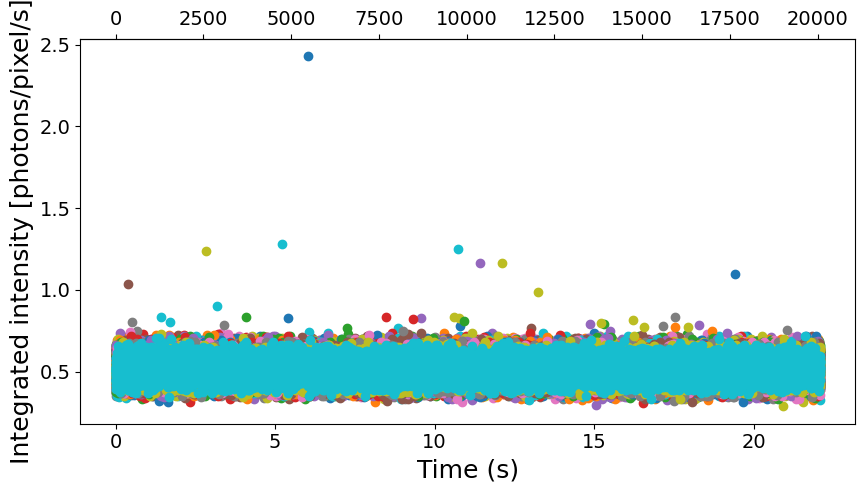

In [120]:
plt.figure(figsize=(10,5))
for data in e4m_data:
    t_It, It = XPCS.get_It(data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
    plt.scatter(t_It, It, label='It')
    
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [35]:
###################
Lbin = 500
bin2dense = False
mask = None
###################
if Lbin is None: Lbin=1

G2t = np.zeros((e4m_data[0].shape[0]//Lbin,e4m_data[0].shape[0]//Lbin))

for data in tqdm(e4m_data):
    with redirect_stdout(io.StringIO()):
        G2t += XPCS.get_G2t(data, mask=mask, Lbin=Lbin, bin2dense=bin2dense)

G2t/=len(e4m_data)

100%|██████████| 50/50 [00:05<00:00,  8.67it/s]


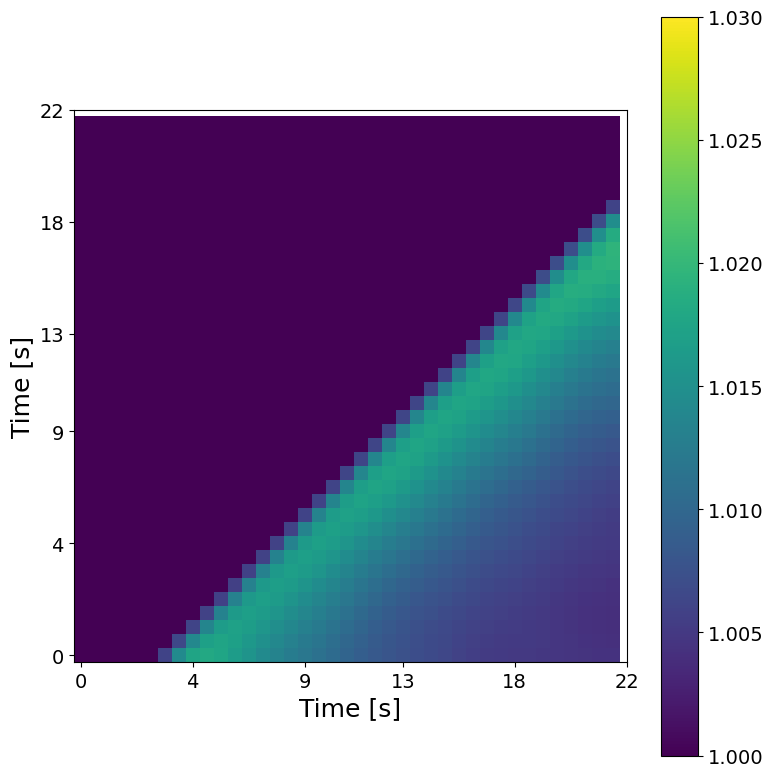

In [36]:
############################
vmin, vmax = 1.0, 1.03
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=None, t2=None, sigma_filter=2)

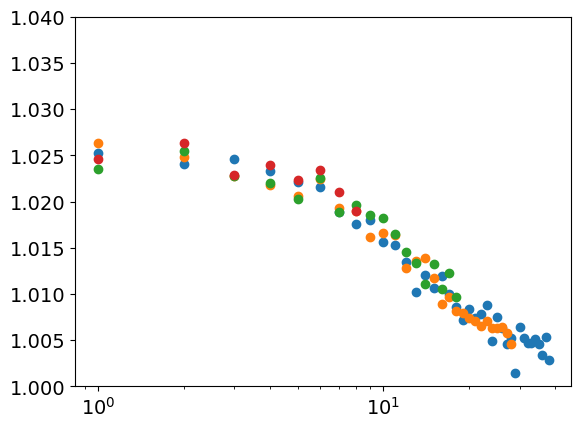

In [38]:
for i in np.arange(0, G2t.shape[0], 10):
    plt.scatter(np.arange(len(G2t[i,i+1:])), G2t[i,i+1:])
plt.ylim(1, 1.04)
plt.xscale('log')

In [82]:
################
Nbunch = 3
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


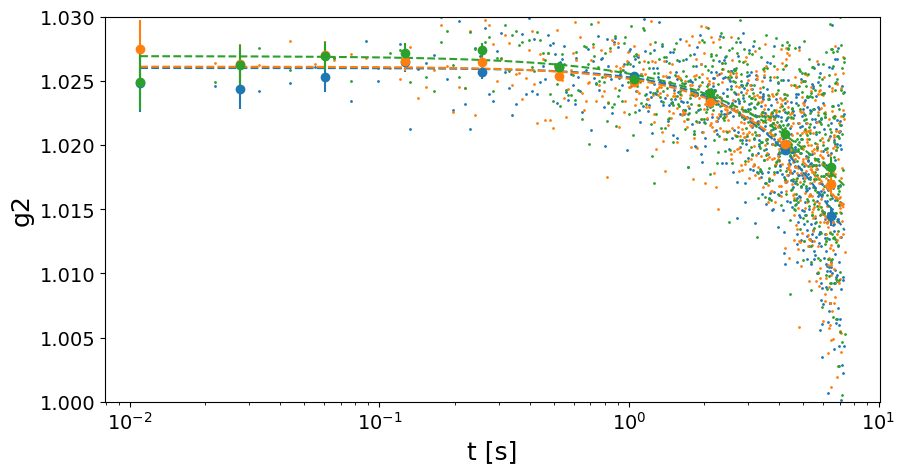

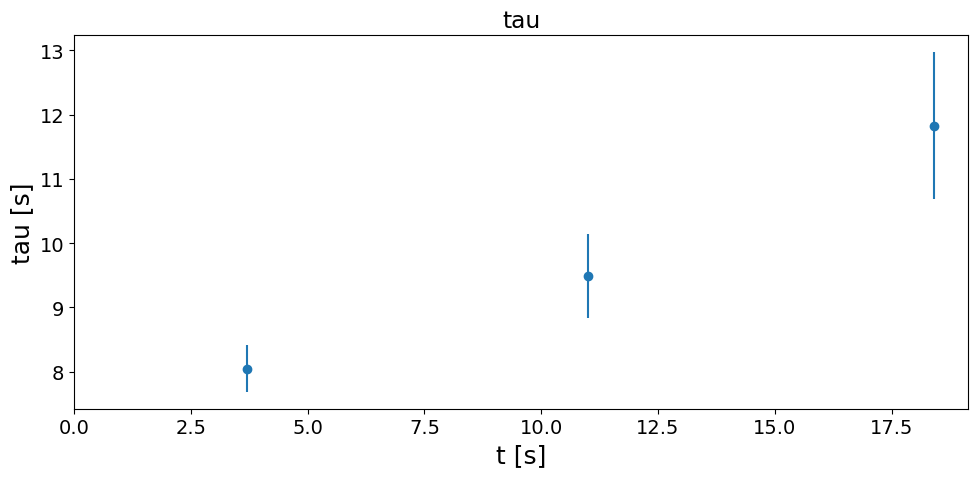

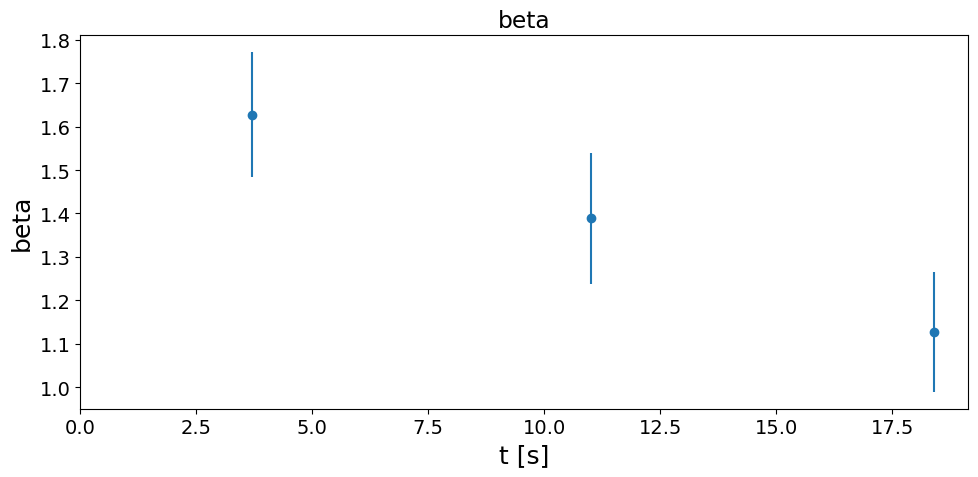

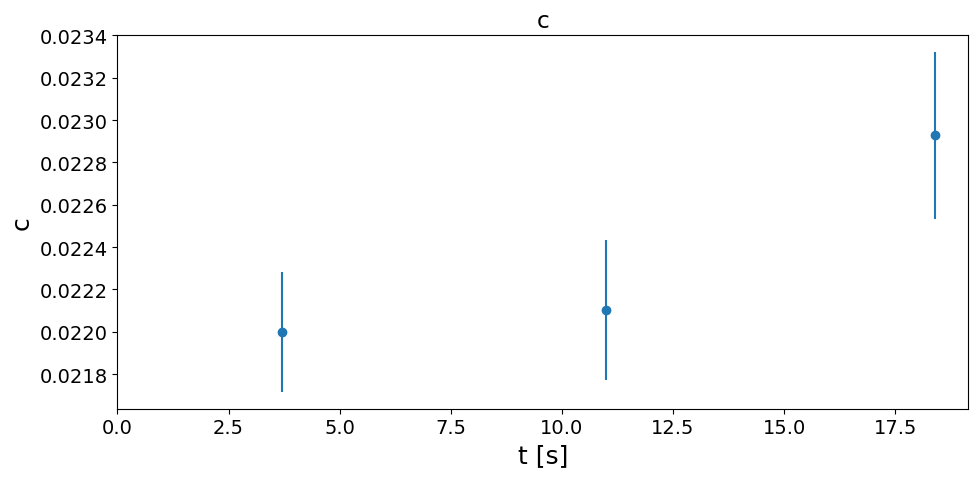

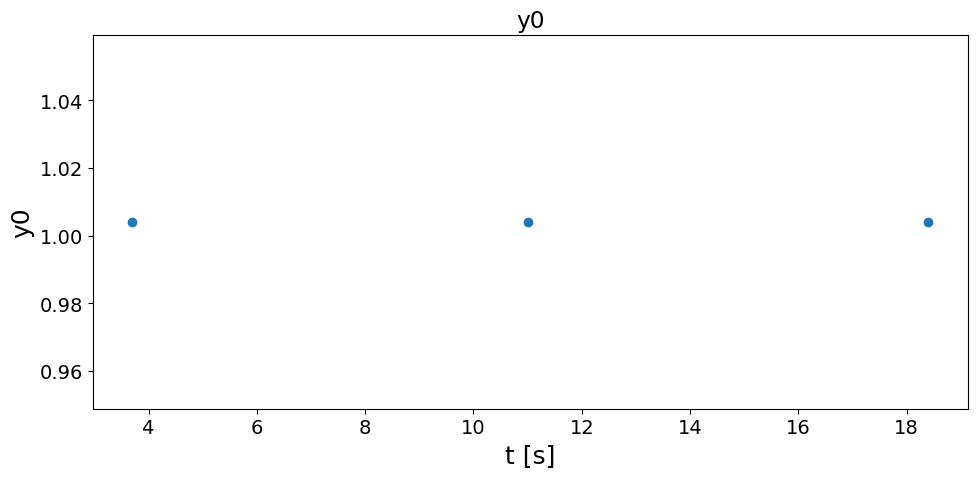

In [84]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=10, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.004014, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [123]:
t_ff = e4m_data[0].shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data[0].shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 20064  =>  t_ff = 22.070400000000003
#############################



In [124]:
########################################
t_segments = [0, 6, 12, t_ff] 
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [129]:
###################
Lbin = 10
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in range(len(Nf_segments)-1):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = np.zeros(((Nff-Nfi)//Lbin, (Nff-Nfi)//Lbin))
            for data in tqdm(e4m_data):
                with redirect_stdout(io.StringIO()):
                    G2t += XPCS.get_G2t(data, mask=mask, Lbin=Lbin, bin2dense=bin2dense, Nfi=Nfi, Nff=Nff)
            G2t/=len(e4m_data)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 50/50 [00:01<00:00, 48.03it/s]


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



100%|██████████| 50/50 [00:00<00:00, 50.21it/s]


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



100%|██████████| 50/50 [00:02<00:00, 22.72it/s]


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


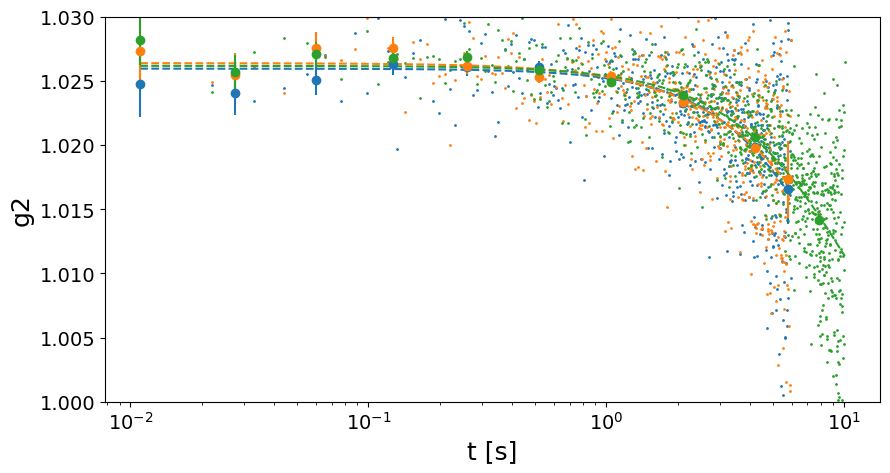

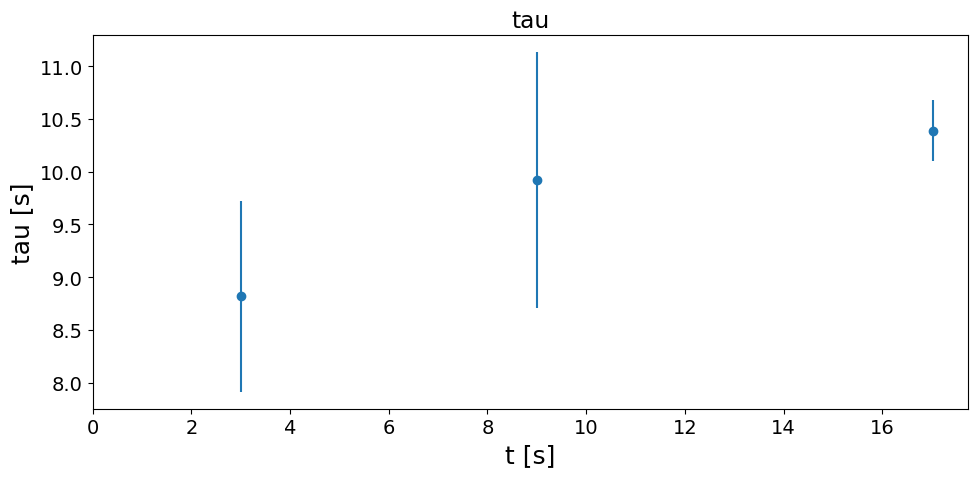

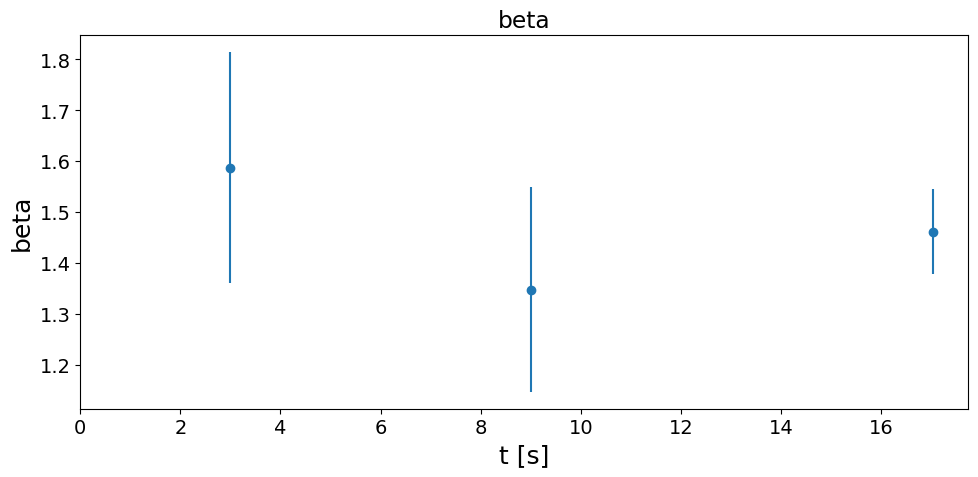

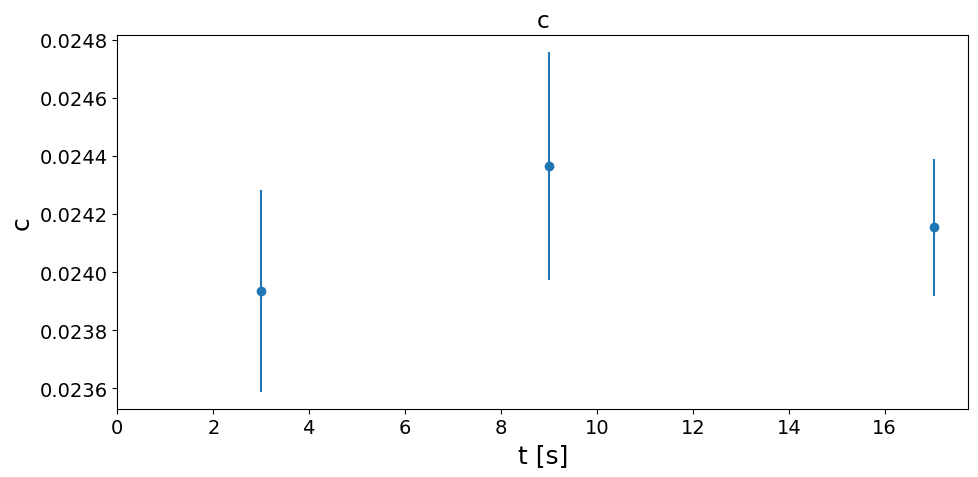

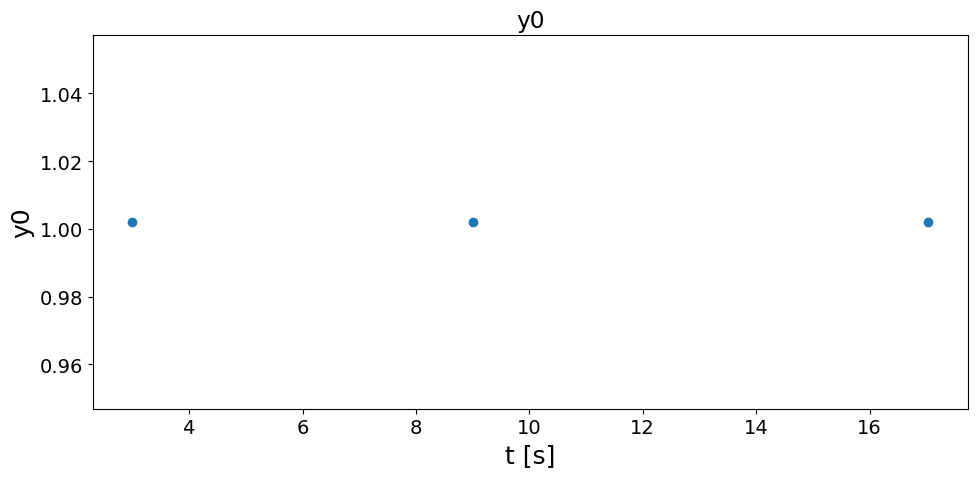

In [130]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1.00202644, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()